In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.signal import butter, filtfilt
from scipy import stats
from scipy.stats import f_oneway, kruskal, pearsonr, spearmanr, sem, permutation_test
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import combinations
from numba import jit
from tqdm import tqdm


warnings.filterwarnings('ignore')

In [2]:
# 数据配置
DATA_TYPE = 'male_high_rank'
ALIGNMENT_POINT = 'i_dm'
BRAIN_REGION = 'mPFC'

# 时间索引
DECISION_MAKING_INDEX = 100
IN_INDEX = 150
OUT_INDEX = 450
NUM_TIMEPOINTS = 600
NUM_TIMEPOINTS_twotrial = 2400

# 跨trial时间索引
DM1_INDEX = 100 # 100
IN1_INDEX = DM1_INDEX + 1 * 50 # 150
OUT1_INDEX = IN1_INDEX + 6 * 50 # 450
T_END1_INDEX = OUT1_INDEX + (3+13) * 50 # 1250
DM2_INDEX = T_END1_INDEX + (11+2) * 50 # 1900
IN2_INDEX = DM2_INDEX + 1 * 50 # 1950
OUT2_INDEX = IN2_INDEX + 6 * 50 # 2250

# 选择转换类型
TRANS_TYPES = ['w-w', 'w-g', 'g-w', 'g-g']

# 颜色配置
CHOICE_TRANSITION_COLORS = {
    'w-w': 'red',
    'g-w': 'purple',
    'w-g': 'dodgerblue',
    'g-g': 'blue'
}

SINGLE_COLORS = {
    'w': 'red',
    'g': 'blue',
}

# 时间窗口
TIME_WINDOWS = {
    "Before turn": (0, DECISION_MAKING_INDEX),
    "In-to-out": (IN_INDEX, OUT_INDEX),
    "After Out": (OUT_INDEX, NUM_TIMEPOINTS)
}

In [3]:
def load_data():
    """加载所有必需的数据文件"""
    file_path_sep_trial = f'./data/reorganized_dataset/{DATA_TYPE}/warped_DA_datasets_{ALIGNMENT_POINT}.pkl'
    file_path_across_trial = f'./data/reorganized_dataset/{DATA_TYPE}/warped_DA_datasets_cross_trial.pkl'
    file_path_matrix = f'./data/reorganized_dataset/{DATA_TYPE}/{BRAIN_REGION}_matrices_{ALIGNMENT_POINT}.pkl'

    with open(file_path_sep_trial, 'rb') as file:
        DA = pickle.load(file)
    with open(file_path_across_trial, 'rb') as file:
        DA_across_trial = pickle.load(file)
    with open(file_path_matrix, 'rb') as f:
        DA_matrix = pickle.load(f)

    return DA, DA_across_trial, DA_matrix


def preprocess_data(DA, DA_across_trial):
    """数据预处理和特征工程"""
    # 过滤脑区
    DA = DA[DA['brain_region'] == BRAIN_REGION]
    DA_across_trial = DA_across_trial[DA_across_trial['brain_region'] == BRAIN_REGION]

    # 创建选择转换特征
    DA['prev_curr_choice'] = DA['prev_choice'] + '-' + DA['current_choice']
    DA['curr_next_choice'] = DA['current_choice'] + '-' + DA['next_choice']
    DA_across_trial['trial1_trial2_choice'] = (
            DA_across_trial['current_choice_1'] + '-' + DA_across_trial['current_choice_2']
    )

    # 转换单位
    DA['warped_signal'] = DA['warped_signal']*100
    DA_across_trial['cross_trial_warped_signal'] = DA_across_trial['cross_trial_warped_signal'] * 100

    # 分割数据集
    DA_wo_baseline = DA[DA['phase_id'] != 'baseline']
    DA_only_baseline = DA[DA['phase_id'] == 'baseline']
    DA_across_trial_wo_baseline = DA_across_trial[DA_across_trial['phase_id'] != 'baseline']
    DA_across_trial_only_baseline = DA_across_trial[DA_across_trial['phase_id'] == 'baseline']

    return DA, DA_wo_baseline, DA_only_baseline, DA_across_trial_wo_baseline, DA_across_trial_only_baseline


# 加载和预处理数据
DA, DA_across_trial, DA_matrix = load_data()
DA, DA_wo_baseline, DA_only_baseline, DA_across_trial_wo_baseline, DA_across_trial_only_baseline = preprocess_data(DA, DA_across_trial)

print(f"数据加载完成:")
print(f"  - 基线期trials: {len(DA_only_baseline)}")
print(f"  - 非基线期trials: {len(DA_wo_baseline)}")
print(f"  - 跨trial数据: {len(DA_across_trial_wo_baseline)}")


数据加载完成:
  - 基线期trials: 115
  - 非基线期trials: 674
  - 跨trial数据: 659


In [4]:
DA_wo_baseline.head()

mouse_id phase_id  trial_id  \
41  0725-11B    win-1         1   
43  0725-11B    win-1         2   
45  0725-11B    win-1         3   
47  0725-11B    win-1         4   
49  0725-11B    win-1         5   

                                        warped_signal  \
41  [-0.9108596082422821, -0.90081831507853, -0.82...   
43  [0.2531637835152487, 0.24667528405212102, 0.26...   
45  [-1.4810346931881508, -1.4560647024047193, -1....   
47  [-1.275199391168031, -1.2223322020332348, -1.1...   
49  [-1.519030252416082, -1.47056731903644, -1.448...   

                                 warped_signal_normed  \
41  [0.18815356800161515, 0.19765799356228955, 0.2...   
43  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
45  [0.2173687867496252, 0.23415617266950958, 0.25...   
47  [0.5076713425600011, 0.5572337087958353, 0.648...   
49  [0.0805019420266822, 0.11748956158954386, 0.13...   

                         warped_out_to_next_in_signal  \
41  [-0.007431465104704754, -0.007850126011348513,...   
43  [-0.014871462934178192, -0.014825651587442723,...   
45  [-0.017080409117421216, -0.01680134014940481, ...   
47  [-0.010059627427321595, -0.010788184156413609,...   
49  [-0.010473802080504087, -0.010579888816933409,...   

                  warped_out_to_next_in_signal_normed  \
41  [0.5072003131037853, 0.47326253930087353, 0.49...   
43  [0.3514235053106561, 0.35740483312550175, 0.36...   
45  [0.1886830899725335, 0.21469661088903572, 0.25...   
47  [0.5959091668442065, 0.5397174153472515, 0.483...   
49  [0.4928304790540858, 0.4834866758908067, 0.468...   

                    warped_prev_out_to_curr_in_signal  \
41                                               None   
43  [-0.007431465104704754, -0.007850126011348513,...   
45  [-0.014871462934178192, -0.014825651587442723,...   
47  [-0.017080409117421216, -0.01680134014940481, ...   
49  [-0.010059627427321595, -0.010788184156413609,...   

             warped_prev_out_to_curr_in_signal_normed  t_start  ...  \
41                                               None  673.000  ...   
43  [0.5072003131037853, 0.47326253930087353, 0.49...  746.300  ...   
45  [0.3514235053106561, 0.35740483312550175, 0.36...  764.167  ...   
47  [0.1886830899725335, 0.21469661088903572, 0.25...  791.467  ...   
49  [0.5959091668442065, 0.5397174153472515, 0.483...  813.933  ...   

    dm_time_rel_idx  i_time_rel_idx  o_time_rel_idx  \
41              100             150             450   
43              100             150             450   
45              100             150             450   
47              100             150             450   
49              100             150             450   

                                        original_df_f  brain_region  \
41  [0.026112637518815346, 0.026244570972359035, 0...          mPFC   
43  [-0.005607911943642887, -0.005671232349866116,...          mPFC   
45  [-0.014810346931881508, -0.014284383296230505,...          mPFC   
47  [-0.008213561710413252, -0.0076294248425896665...          mPFC   
49  [-0.014903232903083862, -0.016132070009308587,...          mPFC   

    current_choice  next_choice prev_choice prev_curr_choice curr_next_choice  
41               g            w        None              NaN              g-w  
43               w            g           g              g-w              w-g  
45               g            g           w              w-g              g-g  
47               g            g           g              g-g              g-g  
49               g            g           g              g-g              g-g  

[5 rows x 24 columns]

In [6]:
def set_layout(ax):
    """统一设置图形样式"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='both', which='major', length=6, width=2, direction='out',
                  color='black', labelsize=10, bottom=True, left=True,
                  top=False, right=False)
    ax.grid(False)
    legend = ax.legend(frameon=False, fontsize=11)
    return legend

def add_event_markers(ax, shift=-150):
    """添加事件标记线"""
    ax.axvline(x=DECISION_MAKING_INDEX + shift, color='k', linestyle='--', linewidth=2)
    ax.axvline(x=IN_INDEX + shift, color='k', linestyle='--', linewidth=2)
    ax.axvline(x=OUT_INDEX + shift, color='k', linestyle='--', linewidth=2)

def add_cross_trial_markers(ax, shift=-150):
    """添加跨trial事件标记"""
    ax.axvline(x=DM1_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=IN1_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=OUT1_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=T_END1_INDEX + shift, color='black', linestyle='-', linewidth=2, alpha=0.8)
    ax.axvline(x=DM2_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=IN2_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=OUT2_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)

def significance_label(p):
    """生成显著性标签"""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return str(p)

In [7]:
def statistic(x, y, axis):
    """置换检验的统计量函数"""
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

@jit(nopython=True)
def _permutation_test_single(test_data, baseline_data, n_permutations, observed_diff, direction):
    """单个时间点的置换检验（Numba优化）"""
    n_test = len(test_data)
    combined = np.concatenate((test_data, baseline_data))
    count = 0
    np.random.seed(42)

    for _ in range(n_permutations):
        perm_idx = np.random.permutation(len(combined))
        perm_combined = combined[perm_idx]
        perm_test = perm_combined[:n_test]
        perm_baseline = perm_combined[n_test:]
        perm_diff = np.mean(perm_test) - np.mean(perm_baseline)

        if direction > 0:
            if perm_diff >= observed_diff:
                count += 1
        else:
            if perm_diff <= observed_diff:
                count += 1

    return (count + 1) / (n_permutations + 1)

def permutation_test_numba(signal_matrix, baseline_start, baseline_end,
                           n_permutations, alpha=0.05):
    """使用Numba加速的置换检验"""
    n_trials, n_timepoints = signal_matrix.shape
    baseline_data = signal_matrix[:, baseline_start:baseline_end].flatten()
    baseline_mean = np.mean(baseline_data)

    p_values = np.ones(n_timepoints)
    directions = np.zeros(n_timepoints)

    for t in tqdm(range(n_timepoints), desc="Numba置换检验"):
        if baseline_start <= t < baseline_end:
            continue

        test_data = signal_matrix[:, t]
        observed_diff = np.mean(test_data) - baseline_mean
        direction = 1 if observed_diff > 0 else -1

        p_value = _permutation_test_single(
            test_data, baseline_data, n_permutations,
            observed_diff, direction
        )

        p_values[t] = p_value
        directions[t] = direction

    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
    sig_increase = [int(t) for t in np.where((directions == 1) & reject)[0]]
    sig_decrease = [int(t) for t in np.where((directions == -1) & reject)[0]]

    return sig_increase, sig_decrease

def plot_permutation_sig(ax, sig_increase, sig_decrease, y, color, offset=150,
                         baseline_start=250, baseline_end=350):
    """绘制置换检验显著性标记"""
    for sig_list, marker in [(sig_increase, '^'), (sig_decrease, 'v')]:
        if sig_list:
            x_coords = np.array(sig_list) - offset
            ax.scatter(x_coords, [y] * len(x_coords), marker=marker, s=10,
                      color=color, alpha=0.8, zorder=10)

    baseline_x_start = baseline_start - offset
    baseline_x_end = baseline_end - offset
    ax.axvspan(baseline_x_start, baseline_x_end, alpha=0.2, color='grey', zorder=0)

# 1 current_choice curve

In [8]:
def plot_current_choice_effects(
    DA_data, phase_name='', n_permutations=0, test_window=(250, 350), stat_level='trial'  # 新增参数：'trial' 或 'mouse'
):
    fig, ax = plt.subplots(figsize=(8, 5))

    current_plot_y = 0.6 if phase_name == 'Baseline' else 0.2

    for choice_group in ['w', 'g']:
        group_data = DA_data[DA_data['current_choice'] == choice_group]

        # 提取 warped_signal
        signal_array = np.array(group_data['warped_signal'].tolist())

        if stat_level == 'mouse':
            # 先按 mouse_id 分组求均值
            mouse_means = []
            for mouse, df_mouse in group_data.groupby('mouse_id'):
                mouse_signal = np.array(df_mouse['warped_signal'].tolist())
                mouse_means.append(mouse_signal.mean(axis=0))
            signal_array = np.array(mouse_means)  # 用 mouse-level 数据做后续计算
            if mouse_signal.mean(axis=0)[550]>0.015:
                print(mouse)

        # 计算均值和 SEM
        mean_signal = signal_array.mean(axis=0)
        signal_sem = sem(signal_array, axis=0)
        x_values = np.arange(len(mean_signal)) - 150

        label = choice_group.upper() + f' (n={signal_array.shape[0]}, {stat_level}-level)'
        color = SINGLE_COLORS[choice_group]

        # for single in signal_array:
        #     ax.plot(x_values, single, color=color, alpha=0.2, linewidth=1, zorder=1)


        # permutation test
        if n_permutations > 0:
            sig_increase, sig_decrease = permutation_test_numba(signal_array, test_window[0], test_window[1], n_permutations=n_permutations)
            plot_permutation_sig(ax, sig_increase, sig_decrease, y=current_plot_y, color=color, baseline_start=test_window[0], baseline_end=test_window[1])
            current_plot_y += 0.05

        # 绘制均值曲线和 SEM
        ax.plot(x_values, mean_signal, label=label, color=color, linewidth=2, zorder=5)
        ax.fill_between(x_values, mean_signal - signal_sem, mean_signal + signal_sem,
                        alpha=0.3, color=color, zorder=4)

    add_event_markers(ax)
    ax.set_title(f'DA curve by Current Choice ({phase_name}, {stat_level}-level)',
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Global dF/F (%)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Points', fontsize=12, fontweight='bold')
    set_layout(ax)
    # plt.ylim(-0.4, 0.8)
    plt.tight_layout()

    sub_idx = '1' if phase_name == 'Baseline' else '2'
    filename = f'1.{sub_idx} DA curve by current choice ({phase_name}, {stat_level}-level)'
    plt.savefig(f'./figs/fig3/{filename}.pdf')
    plt.show()

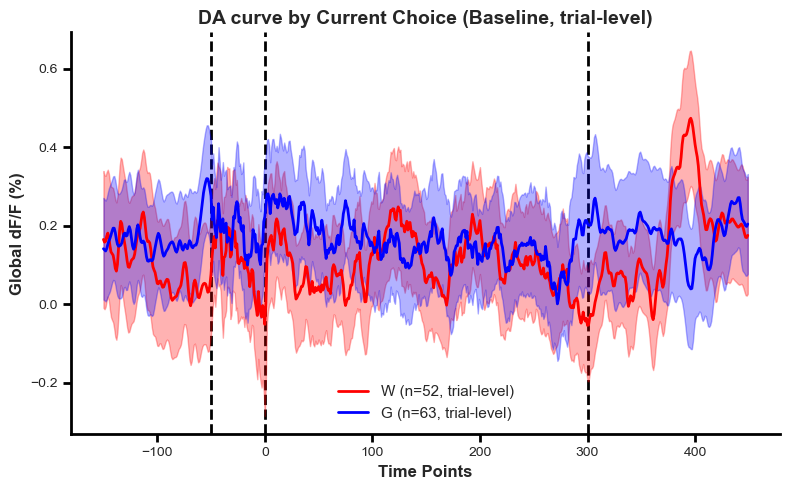

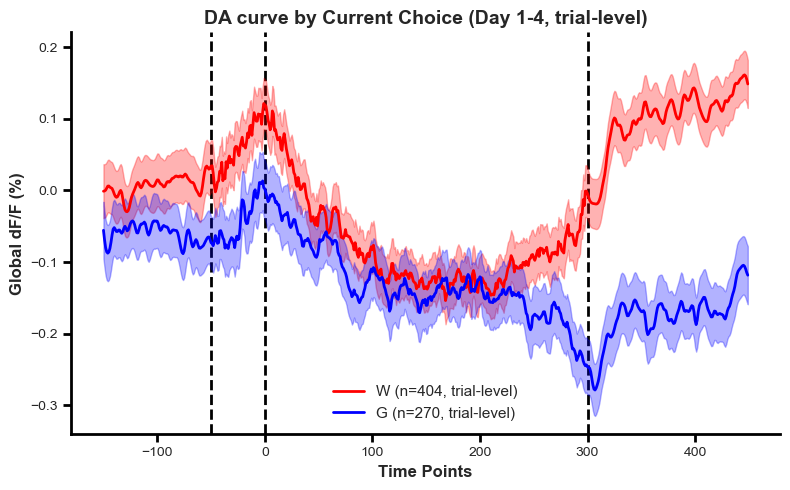

0725-9D


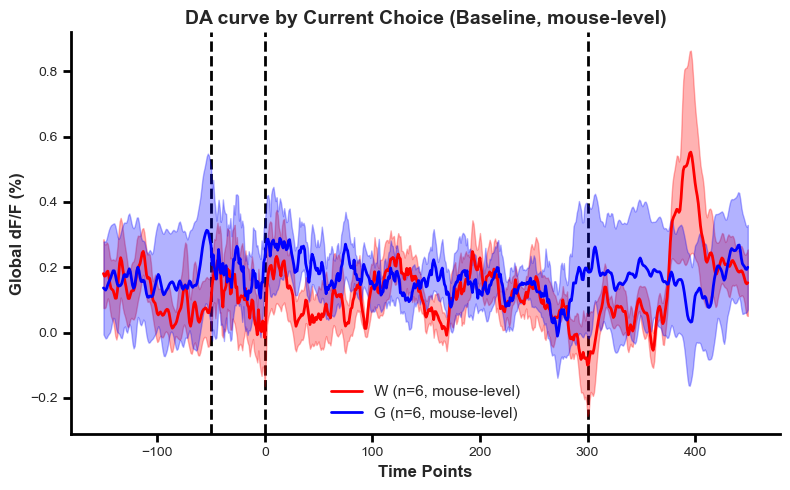

0725-9D


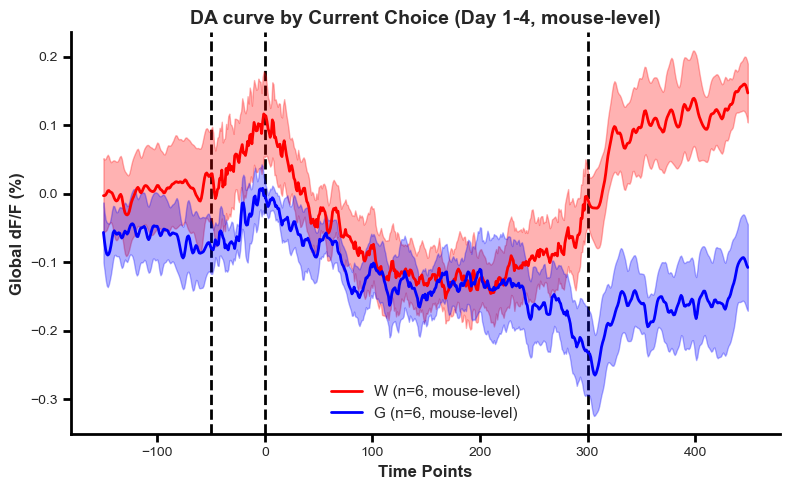

In [9]:
n_permutations = 0
# trial-level
plot_current_choice_effects(DA_only_baseline, phase_name='Baseline', n_permutations=n_permutations, stat_level='trial')
plot_current_choice_effects(DA_wo_baseline, phase_name='Day 1-4', n_permutations=n_permutations, stat_level='trial')
n_permutations = 0
# mouse-level
plot_current_choice_effects(DA_only_baseline, phase_name='Baseline', n_permutations=n_permutations, stat_level='mouse')
plot_current_choice_effects(DA_wo_baseline, phase_name='Day 1-4', n_permutations=n_permutations, stat_level='mouse')

# 2 $\eta^2_p ANOVA$

Degrees of freedom: effect=1, error=646
Eta-squared threshold (p=0.05) = 0.0059


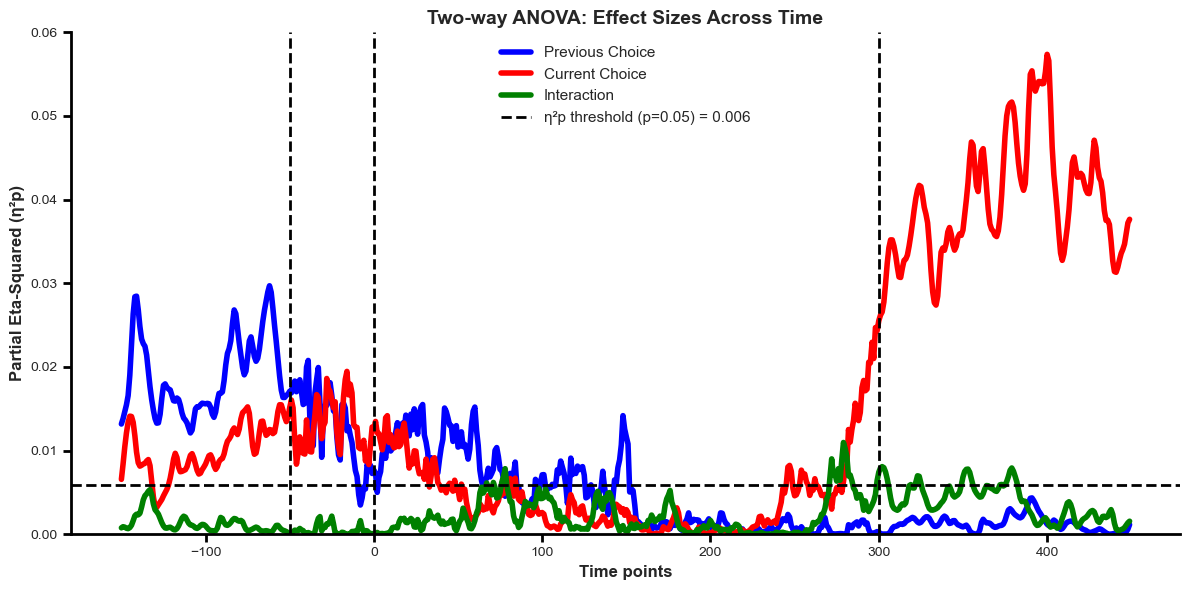

In [10]:
def perform_two_way_anova(data, way1='prev_choice', way2='current_choice'):

    def calculate_partial_eta_squared(anova_table, effect_name):
        """Calculate partial eta-squared from ANOVA table."""
        sum_squares_effect = anova_table.loc[effect_name, "sum_sq"]
        sum_squares_error = anova_table.loc["Residual", "sum_sq"]
        return sum_squares_effect / (sum_squares_effect + sum_squares_error)

    clean_data = data.dropna(
        subset=[way1, way2, 'warped_signal']
    )
    anova_results = []
    p_values_1, p_values_2, p_values_interaction = [], [], []
    eta_squared_1, eta_squared_2, eta_squared_interaction = [], [], []

    for timepoint in range(NUM_TIMEPOINTS):
        timepoint_data = clean_data.copy()
        timepoint_data[f"signal_t{timepoint}"] = timepoint_data['warped_signal'].apply(
            lambda signal: signal[timepoint]
        )
        model = ols(
            f"signal_t{timepoint} ~ C({way1}) * C({way2})",
            data=timepoint_data
        ).fit()
        anova_table = sms.stats.anova_lm(model, typ=2)
        anova_results.append(anova_table)

        # Extract p-values
        p_values_1.append(anova_table.loc[f"C({way1})", "PR(>F)"])
        p_values_2.append(anova_table.loc[f"C({way2})", "PR(>F)"])
        p_values_interaction.append(anova_table.loc[f"C({way1}):C({way2})", "PR(>F)"])

        # Calculate effect sizes (partial eta-squared)
        eta_squared_1.append(calculate_partial_eta_squared(anova_table, f"C({way1})"))
        eta_squared_2.append(calculate_partial_eta_squared(anova_table, f"C({way2})"))
        eta_squared_interaction.append(
            calculate_partial_eta_squared(anova_table, f"C({way1}):C({way2})")
        )

    # Calculate eta-squared threshold for significance
    degrees_freedom_effect = 1
    degrees_freedom_error = int(anova_results[0].loc["Residual", "df"])

    alpha_level = 0.05
    f_critical = stats.f.ppf(1 - alpha_level, degrees_freedom_effect, degrees_freedom_error)
    eta_squared_threshold = (f_critical * degrees_freedom_effect) / (
        f_critical * degrees_freedom_effect + degrees_freedom_error
    )

    print(f"Degrees of freedom: effect={degrees_freedom_effect}, error={degrees_freedom_error}")
    print(f"Eta-squared threshold (p=0.05) = {eta_squared_threshold:.4f}")


    x_values = np.arange(NUM_TIMEPOINTS) - 150
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(x_values, eta_squared_1, label="Previous Choice", color="blue", linewidth=4)
    ax.plot(x_values, eta_squared_2, label="Current Choice", color="red", linewidth=4)
    ax.plot(x_values, eta_squared_interaction, label="Interaction", color="green", linewidth=4)
    ax.axhline(
        eta_squared_threshold,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"η²p threshold (p=0.05) = {eta_squared_threshold:.3f}"
    )

    # Add event markers (平移后的位置)
    ax.axvline(x=IN_INDEX - 150, color='k', linestyle='--', linewidth=2)
    ax.axvline(x=OUT_INDEX - 150, color='k', linestyle='--', linewidth=2)
    ax.axvline(x=DECISION_MAKING_INDEX - 150, color='k', linestyle='--', linewidth=2)
    ax.set_xlabel("Time points", fontsize=12, fontweight='bold')
    ax.set_ylabel("Partial Eta-Squared (η²p)", fontsize=12, fontweight='bold')
    ax.set_ylim(0, 0.06)
    ax.set_title("Two-way ANOVA: Effect Sizes Across Time", fontsize=14, fontweight='bold')
    set_layout(ax)
    plt.tight_layout()
    plt.savefig(f'./figs/fig3/2.1 anova_effect_sizes_{way1}_vs_{way2}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

perform_two_way_anova(DA_wo_baseline)

# 3 choice-choice curve

In [11]:
def plot_choice_transitions(
    data,
    choice_type='prev_curr_choice',
    time_window=(250, 350),
    n_permutations=0,
    plot_individual=False,
    stat_level='trial'
):

    fig, ax = plt.subplots(figsize=(10, 6))
    current_plot_y = 0.3

    for transition_type in TRANS_TYPES:
        transition_data = data[data[choice_type] == transition_type]

        # 根据统计层级处理数据
        if stat_level == 'mouse':
            # 先按鼠标分组，再对每只鼠求均值
            mouse_groups = transition_data.groupby('mouse_id')
            signal_matrix = np.vstack([np.mean(np.vstack(g['warped_signal'].values), axis=0)
                                       for _, g in mouse_groups])
        else:
            # trial level: 直接使用每个trial
            signal_matrix = np.vstack(transition_data['warped_signal'].values)

        if signal_matrix.size == 0:
            continue

        mean_signal = np.mean(signal_matrix, axis=0)
        signal_sem = sem(signal_matrix, axis=0)
        x_values = np.arange(len(mean_signal)) - 150
        color = CHOICE_TRANSITION_COLORS[transition_type]

        # 绘制每个trial的曲线（浅灰色）
        if plot_individual and stat_level == 'trial':
            for single in signal_matrix:
                ax.plot(x_values, single, color='lightgrey', alpha=0.6, linewidth=0.6, zorder=1)

        # permutation test
        if n_permutations > 0:
            sig_increase, sig_decrease = permutation_test_numba(
                signal_matrix, time_window[0], time_window[1], n_permutations=n_permutations
            )
            plot_permutation_sig(ax, sig_increase, sig_decrease, y=current_plot_y, color=color,
                                 offset=150, baseline_start=time_window[0], baseline_end=time_window[1])
            current_plot_y += 0.025

        # 绘制均值曲线和SEM阴影
        ax.plot(x_values, mean_signal, label=transition_type,
                color=color, linewidth=2, zorder=5)
        ax.fill_between(x_values, mean_signal - signal_sem, mean_signal + signal_sem,
                        alpha=0.3, color=color, zorder=4)

    add_event_markers(ax)
    ax.set_title(f'Dopamine Response ({stat_level} level): {choice_type}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Global dF/F (%)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Points', fontsize=12, fontweight='bold')
    # plt.ylim(-0.5, 0.4)

    set_layout(ax)
    plt.tight_layout()
    plt.savefig(f'./figs/fig3/3.1_{choice_type}_{stat_level}_DA_curve.pdf')
    plt.show()


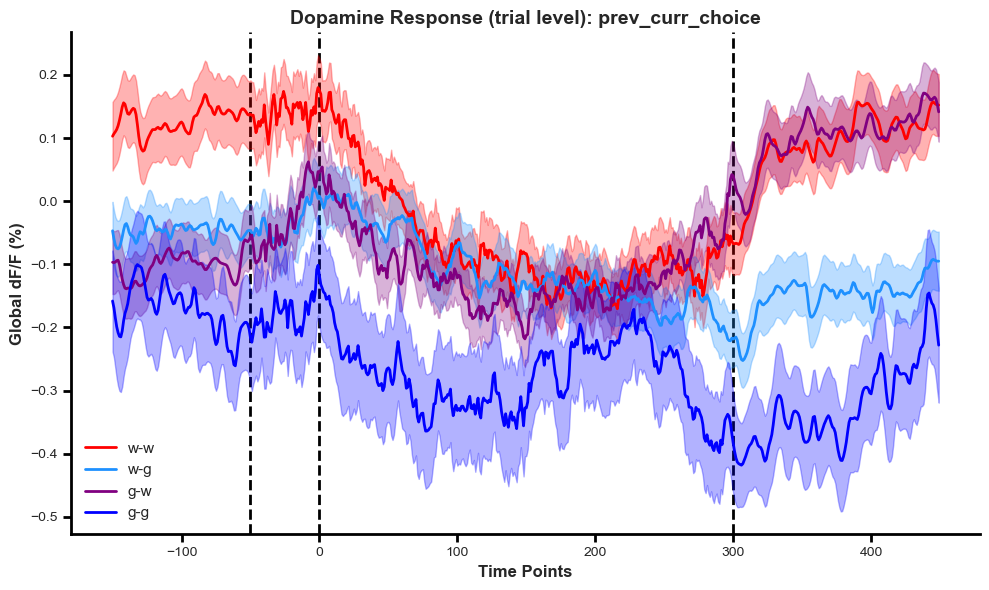

In [12]:
n_permutations = 0
# trial level 统计
plot_choice_transitions(DA_wo_baseline, choice_type='prev_curr_choice', stat_level='trial', n_permutations=n_permutations)
# mouse level 统计
# plot_choice_transitions(DA_wo_baseline, choice_type='prev_curr_choice', stat_level='mouse', n_permutations=n_permutations)

# 4 choice-choice curve stats

In [13]:
def compute_smart_jitter(y_values, width=0.2, y_threshold_ratio=0.05):

    y_values = np.array(y_values)
    n_points = len(y_values)
    if n_points == 0:
        return np.array([])

    # 默认居中
    jitter = np.zeros(n_points)

    if n_points == 1:
        return jitter

    # 根据数据范围定义“过近”阈值
    y_range = y_values.max() - y_values.min() + 1e-6
    threshold = y_threshold_ratio * y_range

    # 按纵坐标排序
    sort_idx = np.argsort(y_values)
    sorted_y = y_values[sort_idx]

    # 分簇
    group = 0
    groups = np.zeros(n_points, dtype=int)
    for i in range(1, n_points):
        if abs(sorted_y[i] - sorted_y[i - 1]) < threshold:
            groups[sort_idx[i]] = group
        else:
            group += 1
            groups[sort_idx[i]] = group

    # 每个簇内部横向均匀分布
    for g in np.unique(groups):
        idx = np.where(groups == g)[0]
        if len(idx) > 1:
            jitter_vals = np.linspace(-width / 4, width / 4, len(idx))
            jitter[idx] = jitter_vals
        else:
            jitter[idx] = 0

    return jitter


===================== Sample Size Summary =====================
time_window transition   n
  After Out        g-g  56
  After Out        g-w 212
  After Out        w-g 203
  After Out        w-w 179
Before turn        g-g  56
Before turn        g-w 212
Before turn        w-g 203
Before turn        w-w 179
  In-to-out        g-g  56
  In-to-out        g-w 212
  In-to-out        w-g 203
  In-to-out        w-w 179

Two-way ANOVA results:
                                  sum_sq      df          F        PR(>F)
C(transition)                  14.502257     3.0  14.697670  1.826223e-09
C(time_window)                  3.555147     2.0   5.404576  4.563981e-03
C(transition):C(time_window)    8.114226     6.0   4.111781  4.152726e-04
Residual                      637.411116  1938.0        NaN           NaN

Tukey HSD for Before turn:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    g-g    g-w    0.0706  0.8650 -0.1635  0.3046   False
1    g-g    w-g    0.1256  0.5147 -0.1095  0.3

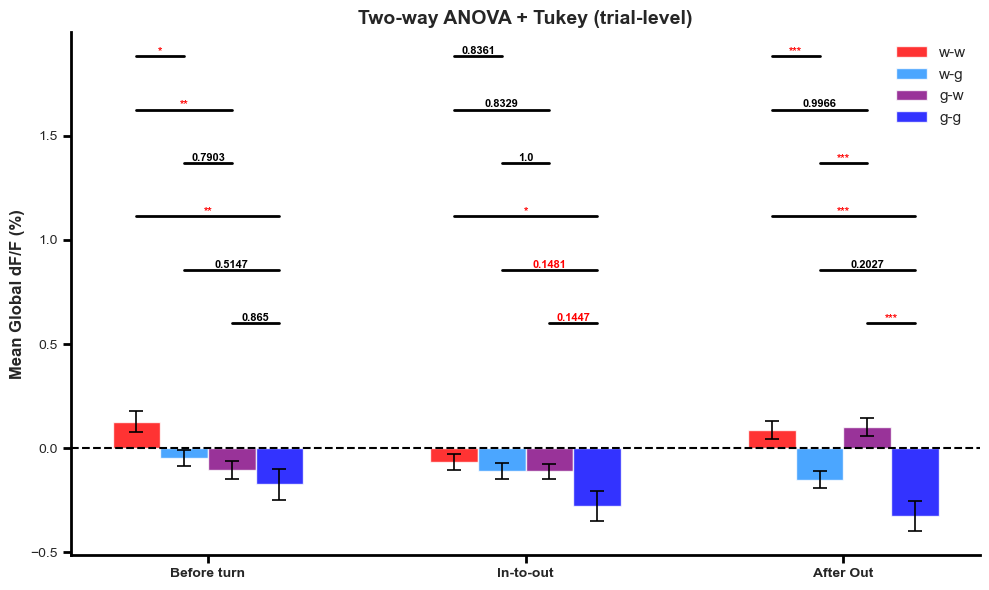


===================== Sample Size Summary =====================
time_window transition  n
  After Out        g-g  6
  After Out        g-w  6
  After Out        w-g  6
  After Out        w-w  6
Before turn        g-g  6
Before turn        g-w  6
Before turn        w-g  6
Before turn        w-w  6
  In-to-out        g-g  6
  In-to-out        g-w  6
  In-to-out        w-g  6
  In-to-out        w-w  6

Two-way ANOVA results:
                                sum_sq    df         F    PR(>F)
C(transition)                 0.847110   3.0  9.605532  0.000029
C(time_window)                0.098519   2.0  1.675686  0.195820
C(transition):C(time_window)  0.295893   6.0  1.677591  0.142159
Residual                      1.763796  60.0       NaN       NaN

Tukey HSD for Before turn:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    g-g    g-w    0.0697  0.9064 -0.2206  0.3600   False
1    g-g    w-g    0.1310  0.5956 -0.1593  0.4213   False
2    g-g    w-w    0.3036  0.0383  0.0134  0.5

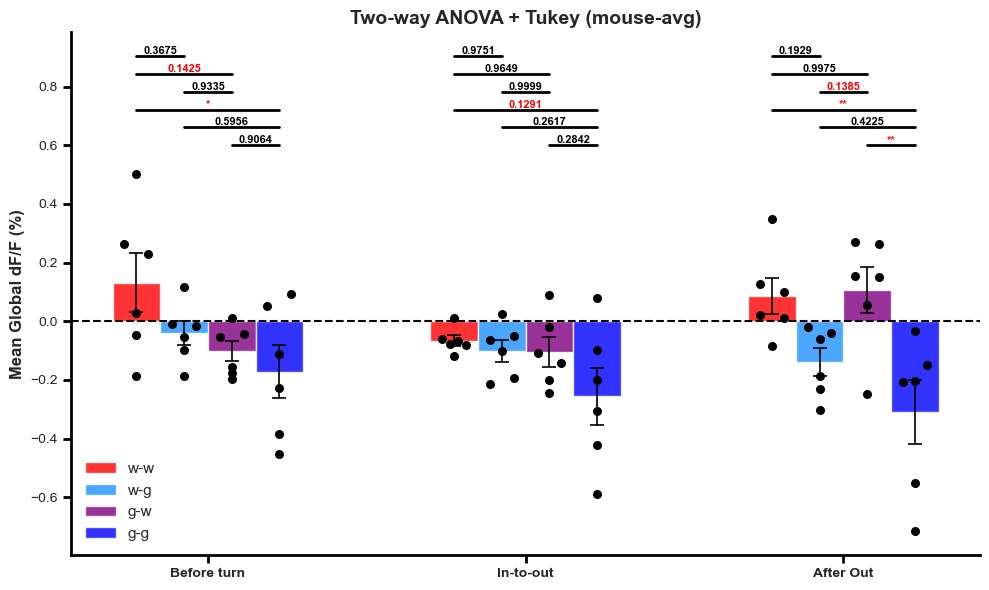

(    mouse_id transition  time_window  mean_signal
 0   0725-11B        w-w  Before turn     0.263656
 1   0725-11B        w-w    In-to-out    -0.061335
 2   0725-11B        w-w    After Out    -0.085920
 3   0725-11C        w-w  Before turn    -0.045333
 4   0725-11C        w-w    In-to-out     0.011749
 ..       ...        ...          ...          ...
 67   0725-7D        g-g    In-to-out    -0.422891
 68   0725-7D        g-g    After Out    -0.550798
 69   0725-9D        g-g  Before turn     0.094210
 70   0725-9D        g-g    In-to-out     0.079225
 71   0725-9D        g-g    After Out    -0.032466
 
 [72 rows x 4 columns],
     time_window transition  n
 0     After Out        g-g  6
 1     After Out        g-w  6
 2     After Out        w-g  6
 3     After Out        w-w  6
 4   Before turn        g-g  6
 5   Before turn        g-w  6
 6   Before turn        w-g  6
 7   Before turn        w-w  6
 8     In-to-out        g-g  6
 9     In-to-out        g-w  6
 10    In-to-out     

In [14]:
def run_two_way_anova_and_plot(data, choice_type='prev_curr_choice', stat_level='mouse'):
    """
    双因素方差分析 + Tukey HSD + 样本量统计 + 绘图
    Parameters:
    - data: 原始DataFrame
    - choice_type: 用于分组的列名
    - stat_level: 'mouse' 或 'trial'，决定是否先对每只鼠取平均
    """
    records = []

    for transition_type in TRANS_TYPES:
        transition_data = data[data[choice_type] == transition_type]

        if stat_level == 'mouse':
            # ⬇️ 对每只鼠取平均
            for mouse_id, mouse_df in transition_data.groupby('mouse_id'):
                for win_name, (start, end) in TIME_WINDOWS.items():
                    mean_vals = []
                    for _, row in mouse_df.iterrows():
                        signal = row['warped_signal']
                        mean_vals.append(np.mean(signal[start:end]))
                    mean_val = np.mean(mean_vals)
                    records.append({
                        "mouse_id": mouse_id,
                        "transition": transition_type,
                        "time_window": win_name,
                        "mean_signal": mean_val
                    })
        elif stat_level == 'trial':
            # ⬇️ 直接用每个trial
            for _, row in transition_data.iterrows():
                signal = row['warped_signal']
                for win_name, (start, end) in TIME_WINDOWS.items():
                    mean_val = np.mean(signal[start:end])
                    records.append({
                        "mouse_id": row['mouse_id'],
                        "transition": transition_type,
                        "time_window": win_name,
                        "mean_signal": mean_val
                    })
        else:
            raise ValueError("stat_level must be 'mouse' or 'trial'")

    df = pd.DataFrame(records)

    # ✅ 输出样本量统计信息
    print("\n===================== Sample Size Summary =====================")
    sample_counts = (
        df.groupby(['time_window', 'transition'])
          .size()
          .reset_index(name='n')
          .sort_values(by=['time_window', 'transition'])
    )
    print(sample_counts.to_string(index=False))
    print("===============================================================\n")

    # 可以按需保存为文件
    sample_counts.to_csv(f'./figs/fig3/sample_counts_{stat_level}.csv', index=False)

    # 双因素方差分析
    model = ols('mean_signal ~ C(transition) * C(time_window)', data=df).fit()
    anova_table = sms.stats.anova_lm(model, typ=2)
    print("Two-way ANOVA results:")
    print(anova_table)

    # Tukey 事后检验
    tukey_results = {}
    for win_name in TIME_WINDOWS.keys():
        sub_df = df[df['time_window'] == win_name]
        tukey = pairwise_tukeyhsd(sub_df['mean_signal'], sub_df['transition'])
        tukey_results[win_name] = pd.DataFrame(
            data=tukey._results_table.data[1:],
            columns=tukey._results_table.data[0]
        )
        print(f"\nTukey HSD for {win_name}:")
        print(tukey_results[win_name])

    # 绘图
    fig, ax = plt.subplots(figsize=(10, 6))
    means = df.groupby(['time_window', 'transition'])['mean_signal'].mean()
    sems = df.groupby(['time_window', 'transition'])['mean_signal'].sem()

    time_order = list(TIME_WINDOWS.keys())
    x = np.arange(len(time_order))
    width = 0.15
    bar_positions = {}

    for i, transition in enumerate(TRANS_TYPES):
        offsets = x + (i - len(TRANS_TYPES) / 2) * width + width / 2
        vals = [means[(tw, transition)] for tw in time_order]
        errs = [sems[(tw, transition)] for tw in time_order]

        # --- 绘制柱状条 ---
        ax.bar(offsets, vals, width, yerr=errs, capsize=5,
               error_kw={'elinewidth': 1.2, 'capthick': 1.2},
               label=transition,
               color=CHOICE_TRANSITION_COLORS[transition],
               alpha=0.8)

        # --- 绘制散点（每只鼠或每个trial） ---
        if stat_level in ['mouse', 'trial']:
            for j, tw in enumerate(time_order):
                bar_positions[(tw, transition)] = offsets[j]
                sub_points = df[(df['time_window'] == tw) & (df['transition'] == transition)]
                y_values = sub_points['mean_signal'].values
                jitter = compute_smart_jitter(y_values, width=width, y_threshold_ratio=0.1)

                if stat_level == 'mouse':
                    ax.scatter(
                        offsets[j] + jitter,
                        y_values,
                        color='black',
                        s=30,
                        zorder=10,
                        marker='o'
                    )

    # --- 添加显著性标记 ---
    for win_name, tukey_df in tukey_results.items():
        y_max = means.max()
        y_offset = (df['mean_signal'].max() - df['mean_signal'].min()) * 0.1
        line_height = 0.6
        step = y_offset * 0

        for idx, row in tukey_df.iterrows():
            g1, g2, pval = row['group1'], row['group2'], row['p-adj']
            x1 = bar_positions[(win_name, g1)]
            x2 = bar_positions[(win_name, g2)]

            ax.plot([x1, x1, x2, x2],
                    [line_height, line_height + step, line_height + step, line_height],
                    color='k', linewidth=2)
            ax.text((x1 + x2) / 2, line_height + step + 0.0003, significance_label(pval),
                    ha='center', va='bottom', fontsize=8,
                    fontweight='bold', color='red' if pval < 0.15 else 'black')
            line_height += y_offset * 0.5

    # --- 美化 ---
    ax.set_xticks(x)
    ax.set_xticklabels(time_order, fontsize=12, fontweight='bold')
    ax.set_ylabel("Mean Global dF/F (%)", fontsize=12, fontweight='bold')
    title_level = "mouse-avg" if stat_level == 'mouse' else "trial-level"
    ax.set_title(f"Two-way ANOVA + Tukey ({title_level})", fontsize=14, fontweight='bold')
    ax.axhline(y=0, color='k', linestyle='--')
    ax.legend()

    set_layout(ax)
    plt.tight_layout()
    plt.savefig(f'./figs/fig3/3.2 stats of four choice-choice ({title_level}).pdf')
    plt.show()

    return df, sample_counts

# 调用示例
run_two_way_anova_and_plot(DA_wo_baseline, stat_level='trial')
run_two_way_anova_and_plot(DA_wo_baseline, stat_level='mouse')


## Save to csv for prism

In [15]:
import pandas as pd
import numpy as np

def export_mean_signal_csv_uniform(data, stat_level='mouse', choice_type='prev_curr_choice'):
    records = []

    for transition_type in TRANS_TYPES:
        transition_data = data[data[choice_type] == transition_type]

        if stat_level == 'mouse':
            for mouse_id, mouse_df in transition_data.groupby('mouse_id'):
                for win_name, (start, end) in TIME_WINDOWS.items():
                    mean_vals = [np.mean(row['warped_signal'][start:end]) for _, row in mouse_df.iterrows()]
                    mean_val = np.mean(mean_vals)
                    records.append({
                        "mouse_id": mouse_id,
                        "transition": transition_type,
                        "time_window": win_name,
                        "mean_signal": mean_val
                    })
        elif stat_level == 'trial':
            for _, row in transition_data.iterrows():
                for win_name, (start, end) in TIME_WINDOWS.items():
                    mean_val = np.mean(row['warped_signal'][start:end])
                    records.append({
                        "transition": transition_type,
                        "time_window": win_name,
                        "mean_signal": mean_val
                    })
        else:
            raise ValueError("stat_level must be 'mouse' or 'trial'")

    df = pd.DataFrame(records)

    # 为每个 transition 生成列名
    df_cols = {}
    max_count = 0
    for t in TRANS_TYPES:
        if stat_level == 'mouse':
            tmp = df[df['transition'] == t].groupby('mouse_id').size()
            col_names = [f"{t}_{mid}" for mid in tmp.index]
        else:
            tmp_count = df[df['transition'] == t].groupby('time_window').cumcount().max() + 1
            col_names = [f"{t}_trial{i+1}" for i in range(tmp_count)]
        df_cols[t] = col_names
        max_count = max(max_count, len(col_names))  # 更新最大列数

    # 构建统一列数的 DataFrame
    pivot_dict = {tw: [] for tw in TIME_WINDOWS.keys()}
    for t in TRANS_TYPES:
        t_df = df[df['transition'] == t]
        for tw in TIME_WINDOWS.keys():
            sub_df = t_df[t_df['time_window'] == tw]
            values = sub_df['mean_signal'].tolist()
            # 填充到 max_count
            values += [np.nan] * (max_count - len(values))
            pivot_dict[tw].extend(values)

    # 构建最终 DataFrame
    all_col_names = []
    for t in TRANS_TYPES:
        all_col_names.extend([f"{t}_{i+1}" for i in range(max_count)])

    df_pivot = pd.DataFrame.from_dict(pivot_dict, orient='index', columns=all_col_names)
    df_pivot.index.name = 'time_window'

    # 保存 CSV
    filename = f'./data/results/stats_csv/mean_signal_{stat_level}.csv'
    df_pivot.to_csv(filename)
    print(f"Exported CSV: {filename}")

# 调用示例
export_mean_signal_csv_uniform(DA_wo_baseline, stat_level='mouse')
export_mean_signal_csv_uniform(DA_wo_baseline, stat_level='trial')


Exported CSV: ./data/results/stats_csv/mean_signal_mouse.csv
Exported CSV: ./data/results/stats_csv/mean_signal_trial.csv


# 5 trial level heatmap

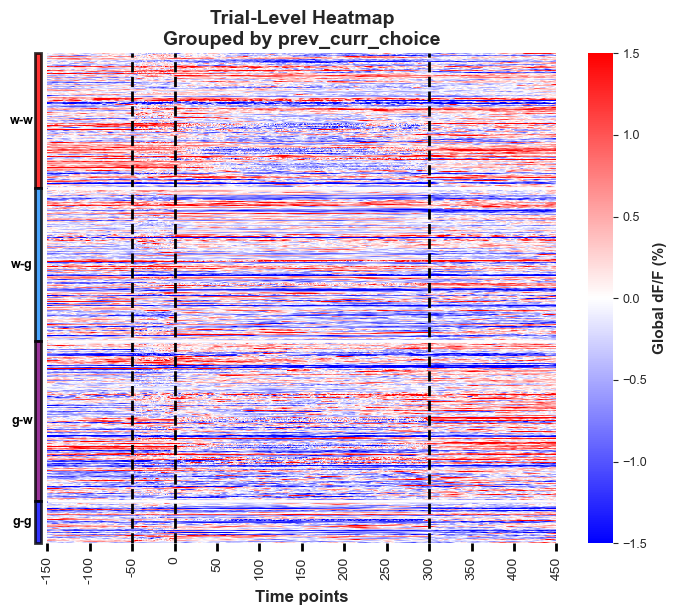

In [16]:
def create_trial_level_heatmap(data, choice_type='prev_curr_choice'):
    """创建按选择转换类型分组的trial级热图"""
    colors = ['red', 'dodgerblue', 'purple', 'blue']

    all_signals = []
    category_boundaries = []
    category_labels = []

    for transition in TRANS_TYPES:
        transition_data = data[data[choice_type] == transition]

        if len(transition_data) == 0:
            continue

        # 按0-100均值排序
        # transition_data = transition_data.copy()
        # transition_data["mean_0_100"] = transition_data["warped_signal"].apply(
        #     lambda x: np.mean(x[:100])
        # )
        # transition_data = transition_data.sort_values("mean_0_100", ascending=False)

        for _, row in transition_data.iterrows():
            all_signals.append(row['warped_signal'])

        category_boundaries.append(len(all_signals))
        category_labels.append(transition)

    if len(all_signals) == 0:
        print("No data available")
        return

    signal_matrix = np.array(all_signals)
    shift = -150

    plt.figure(figsize=(7, len(signal_matrix) * 0.005 + 3))
    ax = sns.heatmap(signal_matrix, yticklabels=False, cmap='bwr',
                    vmin=-1.5, vmax=1.5, cbar_kws={'label': 'Global dF/F (%)'},
                    rasterized=True)

    # 设置colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Global dF/F (%)", fontsize=11, fontweight='bold')

    # 横轴刻度
    x_vals = np.arange(-150, 451, 50)
    ax.set_xticks(x_vals - shift)
    ax.set_xticklabels(x_vals)

    # 事件标记线
    for xline in [DECISION_MAKING_INDEX, IN_INDEX, OUT_INDEX]:
        plt.axvline(x=xline, color='k', linestyle='--', linewidth=2)

    # 类别分隔线
    for boundary in category_boundaries[:-1]:
        ax.hlines(boundary, *ax.get_xlim(), colors='white', linewidth=2)

    # 左侧类别标签框
    mid_points = [0] + category_boundaries
    for i, label in enumerate(category_labels):
        y0 = mid_points[i]
        height = mid_points[i+1] - mid_points[i]
        rect = patches.Rectangle((-15, y0), width=8, height=height, linewidth=2,
                                edgecolor='black', facecolor=colors[i % len(colors)],
                                alpha=0.8, transform=ax.transData, clip_on=False)
        ax.add_patch(rect)
        ax.text(-30, y0 + height/2, label, va='center', ha='center',
               fontsize=9, fontweight='bold', color='k')

    set_layout(ax)
    plt.xlabel("Time points", fontsize=12, fontweight='bold')
    plt.ylabel("")
    plt.title(f"Trial-Level Heatmap\nGrouped by {choice_type}",
             fontsize=14, fontweight='bold')
    plt.tight_layout()

    plt.savefig(f"./figs/fig3/3.3 heatmap_{choice_type}.pdf", format="pdf", dpi=150)
    plt.show()

create_trial_level_heatmap(data=DA_wo_baseline, choice_type='prev_curr_choice')

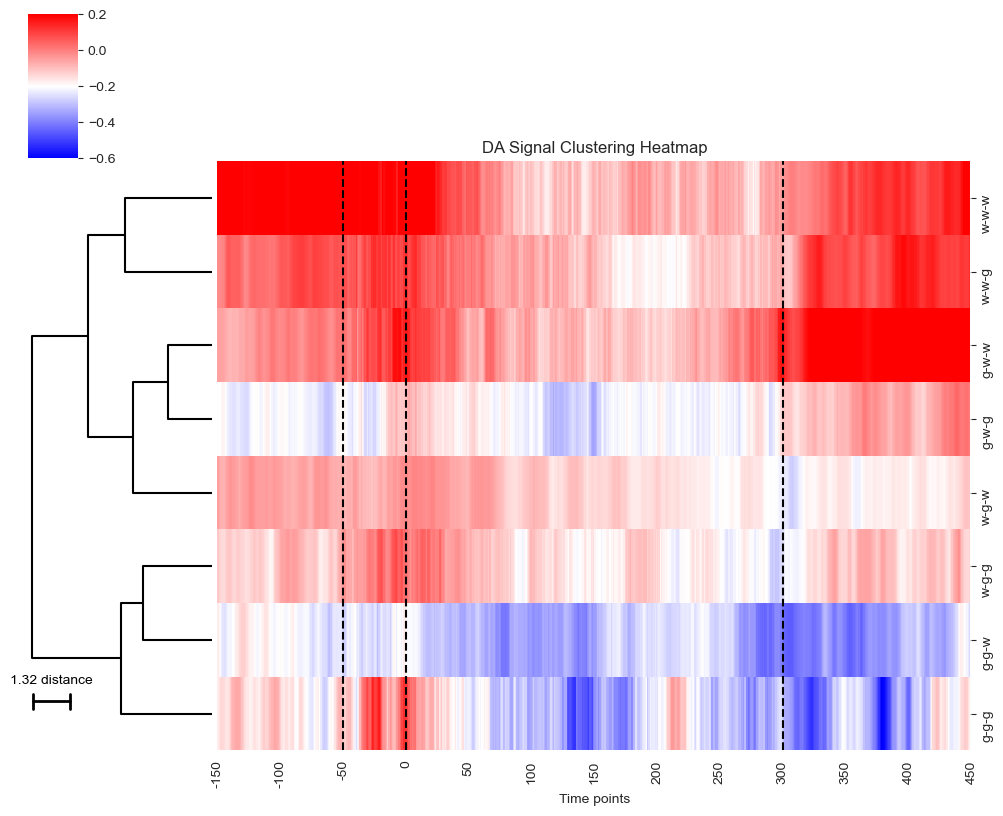

In [17]:
def analyze_three_choice_patterns():
    """分析三选择模式(prev-current-next)的DA信号"""
    three_choice_patterns = [
        f"{prev}-{current}-{next}"
        for prev in ['w', 'g']
        for current in ['w', 'g']
        for next in ['w', 'g']
    ]

    pattern_colors = {
        'w-w-w': '#b22222', 'g-w-w': '#ff7f7f', 'w-w-g': '#8b0000', 'g-w-g': '#fa8072',
        'w-g-w': '#00008b', 'g-g-w': '#87cefa', 'w-g-g': '#4169e1', 'g-g-g': '#add8e6'
    }

    signal_start, signal_end = 0, 599
    pattern_signals = []

    # 收集所有模式的信号
    for pattern in three_choice_patterns:
        prev_choice, current_choice, next_choice = pattern.split('-')

        pattern_data = DA_wo_baseline[
            (DA_wo_baseline['prev_choice'] == prev_choice) &
            (DA_wo_baseline['current_choice'] == current_choice) &
            (DA_wo_baseline['next_choice'] == next_choice)
        ]

        if len(pattern_data) > 0:
            signal_segment = np.mean(pattern_data['warped_signal'].values)[signal_start:signal_end]
            pattern_signals.append((pattern, signal_segment))

    # 层次聚类分析
    if pattern_signals:
        signal_dataframe = pd.DataFrame({
            'pattern': [x[0] for x in pattern_signals],
            'signal': [x[1] for x in pattern_signals]
        })

        signal_matrix = np.array(signal_dataframe['signal'].tolist())
        Z = linkage(signal_matrix, method="average")

        # 生成clustermap
        g = sns.clustermap(signal_matrix, row_linkage=Z, col_cluster=False,
                          yticklabels=signal_dataframe['pattern'].tolist(),
                          cmap="bwr", figsize=(10, 8), vmin=-0.6, vmax=0.2)

        # 设置横轴
        ax = g.ax_heatmap
        xticks = np.arange(0, 601, 50)
        xlabels = np.arange(-150, 451, 50)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)
        ax.set_xlabel("Time points")

        # 事件标记线
        ax.axvline(x=IN_INDEX, color='k', linestyle='--')
        ax.axvline(x=OUT_INDEX, color='k', linestyle='--')
        ax.axvline(x=DECISION_MAKING_INDEX, color='k', linestyle='--')
        ax.set_title("DA Signal Clustering Heatmap")

        # 优化dendrogram
        g.ax_row_dendrogram.clear()
        dendrogram(Z, orientation="left", ax=g.ax_row_dendrogram,
                  color_threshold=None, above_threshold_color="black",
                  link_color_func=lambda k: "black")

        g.ax_row_dendrogram.set_xticks([])
        g.ax_row_dendrogram.set_yticks([])
        g.ax_row_dendrogram.set_frame_on(False)
        g.ax_row_dendrogram.grid(False)

        for line in g.ax_row_dendrogram.get_lines():
            line.set_linewidth(2.0)

        # 添加比例尺
        ax_den = g.ax_row_dendrogram
        x_min, x_max = ax_den.get_xlim()
        scale_length = (x_max - x_min) * 0.2
        scale_value = round(scale_length, 2)
        y_pos = (ax_den.get_ylim()[0] + ax_den.get_ylim()[1]) / 12

        ax_den.plot([x_min + 0.05 * (x_max - x_min),
                    x_min + 0.05 * (x_max - x_min) + scale_length],
                   [y_pos, y_pos], color="k", lw=2)
        ax_den.plot([x_min + 0.05 * (x_max - x_min)]*2,
                   [y_pos-1, y_pos+1], color="k", lw=2)
        ax_den.plot([x_min + 0.05 * (x_max - x_min) + scale_length]*2,
                   [y_pos-1, y_pos+1], color="k", lw=2)
        ax_den.text(x_min + 0.05 * (x_max - x_min) + scale_length/2, y_pos+2,
                   f"{-scale_value} distance", ha="center", va="bottom", color="k")

        plt.savefig("./figs/fig3/4 clustermap.pdf", format="pdf")
        plt.show()

analyze_three_choice_patterns()

In [18]:
three_choice_patterns = [
        f"{prev}-{current}-{next}"
        for prev in ['w', 'g']
        for current in ['w', 'g']
        for next in ['w', 'g']
    ]

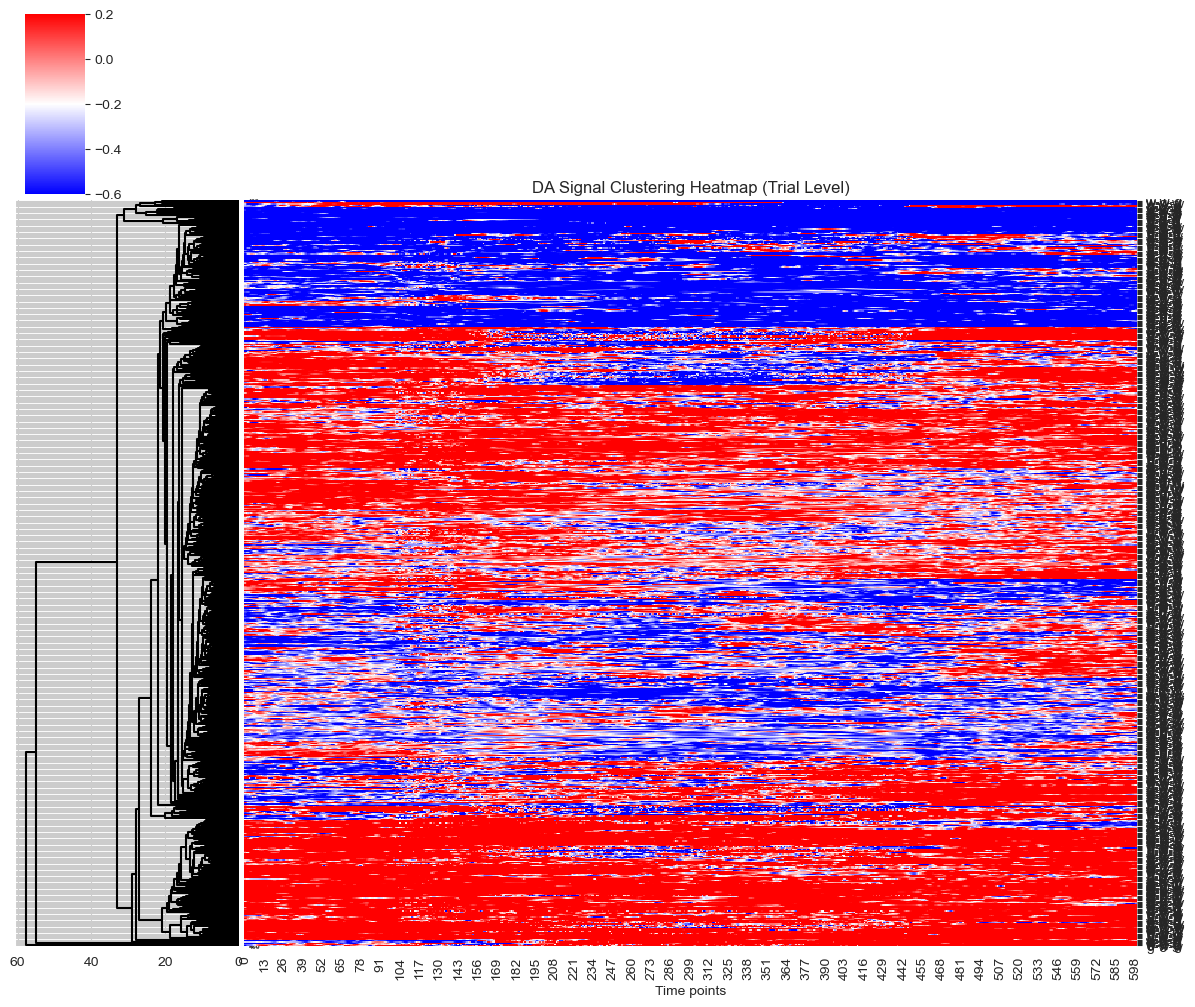

Permutation tests: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


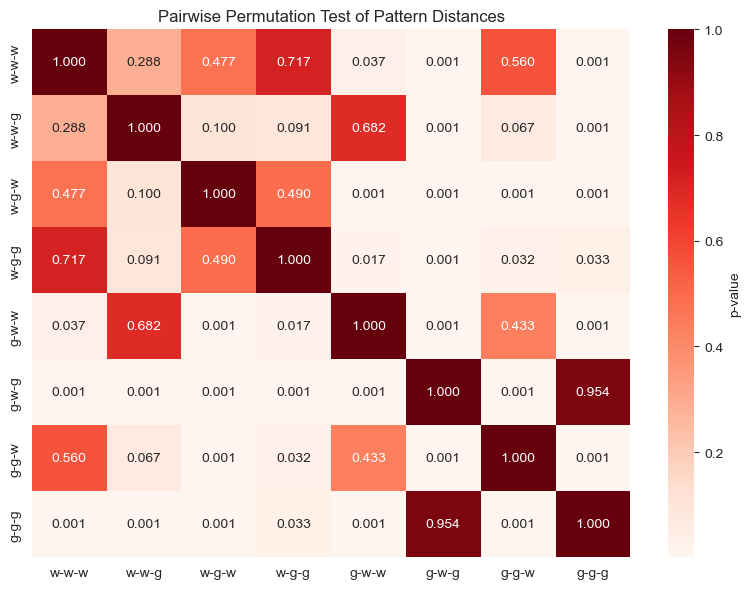

w-w-w: n_trials=72, mean_intra_distance=20.7818
w-w-g: n_trials=102, mean_intra_distance=21.2979
w-g-w: n_trials=155, mean_intra_distance=20.2873
w-g-g: n_trials=41, mean_intra_distance=20.3400
g-w-w: n_trials=104, mean_intra_distance=21.3721
g-w-g: n_trials=101, mean_intra_distance=23.1171
g-g-w: n_trials=42, mean_intra_distance=18.2801
g-g-g: n_trials=11, mean_intra_distance=23.8380


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, cdist, squareform
from itertools import combinations
from tqdm import tqdm  # 用于显示进度条

def permutation_test(distances, intra, n_permutations=1000):
    """两组距离的置换检验"""
    combined = np.concatenate([distances, intra])
    n_distances = len(distances)
    observed_diff = distances.mean() - intra.mean()
    count = 0
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_dist = combined[:n_distances]
        perm_intra = combined[n_distances:]
        perm_diff = perm_dist.mean() - perm_intra.mean()
        if abs(perm_diff) >= abs(observed_diff):
            count += 1
    p_val = (count + 1) / (n_permutations + 1)  # +1 保证不为0
    return p_val

def analyze_three_choice_patterns_full_permutation():
    """Trial-level分析三选择模式、模式间距离统计以及两两显著性检验（置换检验）"""
    three_choice_patterns = [
        f"{prev}-{current}-{next}"
        for prev in ['w', 'g']
        for current in ['w', 'g']
        for next in ['w', 'g']
    ]

    signal_start, signal_end = 0, 599
    trial_signals = []
    trial_labels = []

    # --------------------- 收集 trial 信号 ---------------------
    for pattern in three_choice_patterns:
        prev_choice, current_choice, next_choice = pattern.split('-')
        pattern_data = DA_wo_baseline[
            (DA_wo_baseline['prev_choice'] == prev_choice) &
            (DA_wo_baseline['current_choice'] == current_choice) &
            (DA_wo_baseline['next_choice'] == next_choice)
        ]
        for _, row in pattern_data.iterrows():
            trial_signals.append(row['warped_signal'][signal_start:signal_end])
            trial_labels.append(pattern)

    trial_signals = np.array(trial_signals)

    # --------------------- 层次聚类 ---------------------
    Z = linkage(trial_signals, method="average")
    g = sns.clustermap(trial_signals, row_linkage=Z, col_cluster=False,
                       yticklabels=trial_labels, cmap="bwr", figsize=(12, 10),
                       vmin=-0.6, vmax=0.2)
    ax = g.ax_heatmap
    ax.set_xlabel("Time points")
    ax.set_title("DA Signal Clustering Heatmap (Trial Level)")
    g.ax_row_dendrogram.clear()
    dendrogram(Z, orientation="left", ax=g.ax_row_dendrogram,
               color_threshold=None, above_threshold_color="black",
               link_color_func=lambda k: "black")
    plt.show()

    # --------------------- 模式内统计 ---------------------
    pattern_stats = {}
    for pattern in three_choice_patterns:
        pattern_trials = trial_signals[np.array(trial_labels) == pattern]
        n_trials = len(pattern_trials)
        if n_trials > 1:
            dist_matrix = squareform(pdist(pattern_trials, metric='euclidean'))
            mean_intra_distance = np.sum(dist_matrix) / (n_trials*(n_trials-1))
        else:
            mean_intra_distance = np.nan
        pattern_stats[pattern] = {'n_trials': n_trials, 'mean_intra_distance': mean_intra_distance}

    # --------------------- 模式间平均距离矩阵 ---------------------
    inter_pattern_matrix = np.zeros((len(three_choice_patterns), len(three_choice_patterns)))
    for i, p1 in enumerate(three_choice_patterns):
        trials1 = trial_signals[np.array(trial_labels) == p1]
        for j, p2 in enumerate(three_choice_patterns):
            trials2 = trial_signals[np.array(trial_labels) == p2]
            if len(trials1) > 0 and len(trials2) > 0:
                dist_matrix = cdist(trials1, trials2, metric='euclidean')
                inter_pattern_matrix[i, j] = dist_matrix.mean()
            else:
                inter_pattern_matrix[i, j] = np.nan

    # --------------------- 两两模式置换检验 ---------------------
    pval_matrix = np.ones((len(three_choice_patterns), len(three_choice_patterns)))
    for i, j in tqdm(list(combinations(range(len(three_choice_patterns)), 2)), desc="Permutation tests"):
        p1, p2 = three_choice_patterns[i], three_choice_patterns[j]
        trials1 = trial_signals[np.array(trial_labels) == p1]
        trials2 = trial_signals[np.array(trial_labels) == p2]
        if len(trials1) > 0 and len(trials2) > 0:
            distances = cdist(trials1, trials2, metric='euclidean').flatten()
            intra1 = cdist(trials1, trials1, metric='euclidean')
            intra1 = intra1[np.triu_indices_from(intra1, k=1)]
            p_val = permutation_test(distances, intra1, n_permutations=1000)
            pval_matrix[i, j] = p_val
            pval_matrix[j, i] = p_val

    # --------------------- 可视化 ---------------------
    plt.figure(figsize=(8,6))
    sns.heatmap(pval_matrix, xticklabels=three_choice_patterns, yticklabels=three_choice_patterns,
                cmap='Reds', annot=True, fmt=".3f", cbar_kws={'label':'p-value'})
    plt.title("Pairwise Permutation Test of Pattern Distances")
    plt.tight_layout()
    plt.show()

    return pattern_stats, inter_pattern_matrix, pval_matrix

# 调用函数
pattern_stats, inter_pattern_matrix, pval_matrix = analyze_three_choice_patterns_full_permutation()

# 输出模式内统计
for pattern, stats in pattern_stats.items():
    print(f"{pattern}: n_trials={stats['n_trials']}, mean_intra_distance={stats['mean_intra_distance']:.4f}")


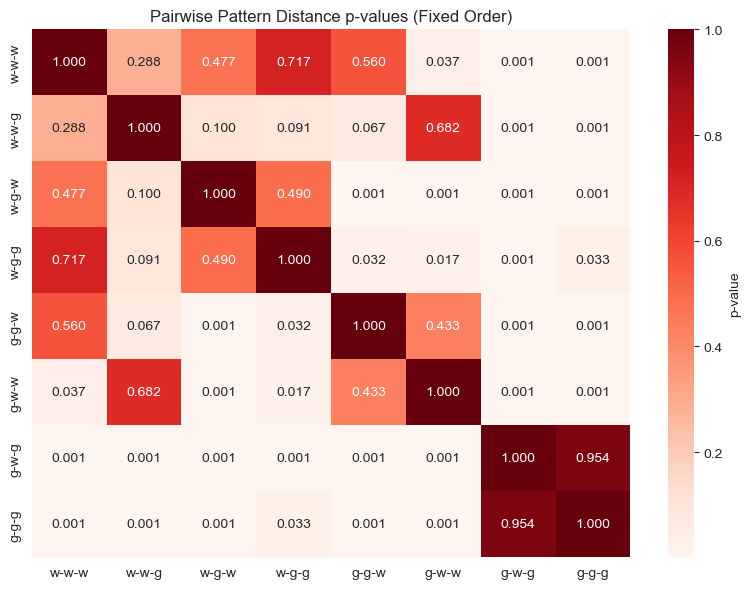

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 固定顺序
fixed_order = ["w-w-w","w-w-g","w-g-w","w-g-g",
               "g-g-w","g-w-w","g-w-g","g-g-g"]

# 将标签映射到 index
pattern_to_idx = {p: i for i, p in enumerate(three_choice_patterns)}

# 根据固定顺序生成新的排列索引
order = [pattern_to_idx[p] for p in fixed_order]

# 根据固定顺序重新排列矩阵和标签
pval_matrix_sorted = pval_matrix[np.ix_(order, order)]
labels_sorted = fixed_order

# 绘制 heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    pval_matrix_sorted,
    xticklabels=labels_sorted,
    yticklabels=labels_sorted,
    cmap='Reds',
    annot=True,
    fmt=".3f",
    cbar_kws={'label':'p-value'}
)
plt.title("Pairwise Pattern Distance p-values (Fixed Order)")
plt.tight_layout()
plt.savefig('./figs/stats_for_cluster_heatmap.pdf', dpi=300)
plt.show()


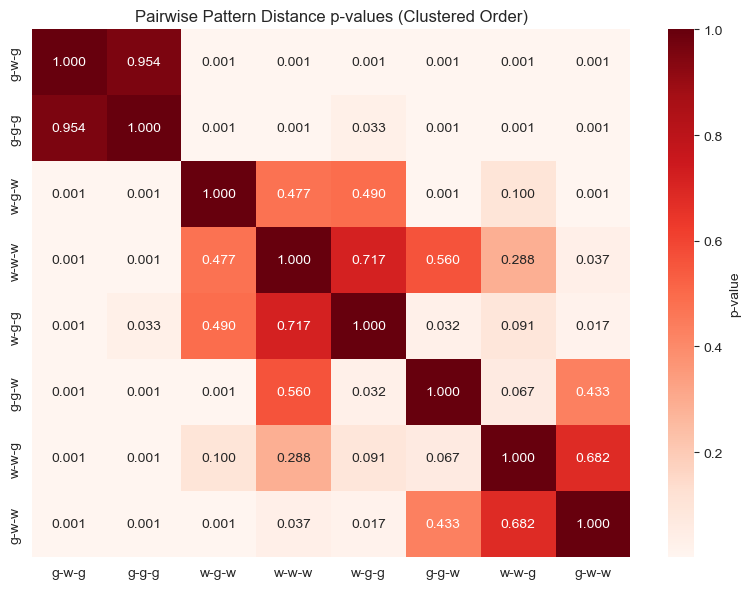

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

# 假设 pval_matrix 已经计算好，three_choice_patterns 已经定义

# 层次聚类：对行聚类
Z = linkage(pval_matrix, method='ward')
order = leaves_list(Z)  # 聚类得到的新顺序

# 根据聚类顺序重新排列矩阵和标签
pval_matrix_sorted = pval_matrix[np.ix_(order, order)]
labels_sorted = [three_choice_patterns[i] for i in order]

# 绘制 heatmap
plt.figure(figsize=(8,6))
sns.heatmap(pval_matrix_sorted, xticklabels=labels_sorted, yticklabels=labels_sorted,
            cmap='Reds', annot=True, fmt=".3f", cbar_kws={'label':'p-value'})
plt.title("Pairwise Pattern Distance p-values (Clustered Order)")
plt.tight_layout()
plt.savefig('./figs/stats_for_cluster_heatmap.pdf', dpi=300)
plt.show()


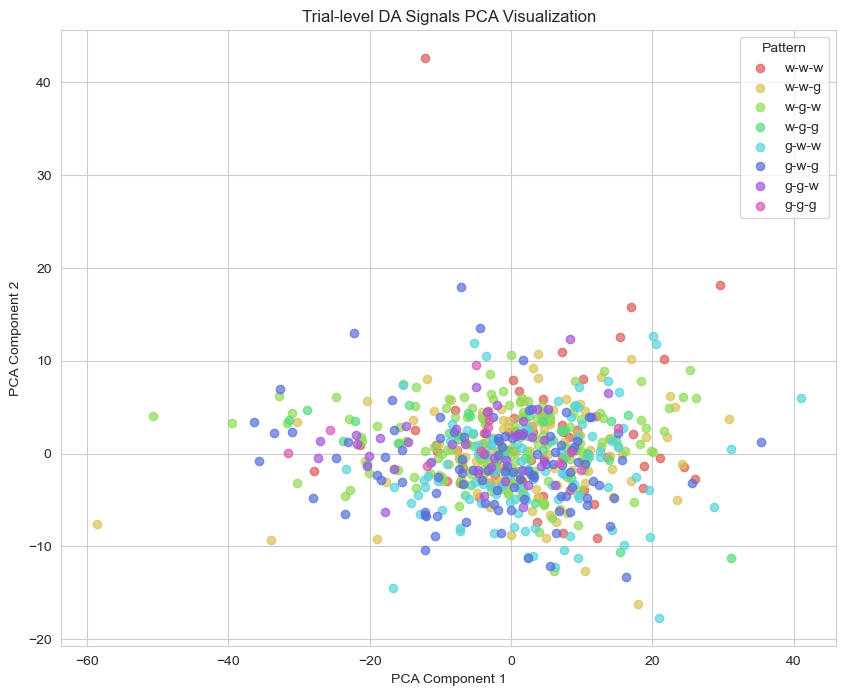

Explained variance ratio: [0.55990139 0.09386862]


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def trial_level_pca_visualization(DA_wo_baseline, signal_start=0, signal_end=599):
    """
    对 trial-level DA 信号做 PCA 降维到二维，并按模式可视化
    DA_wo_baseline: DataFrame，包含 'prev_choice','current_choice','next_choice','warped_signal'
    """
    # ---------------------
    # 模式列表
    # ---------------------
    three_choice_patterns = [
        f"{prev}-{current}-{next}"
        for prev in ['w', 'g']
        for current in ['w', 'g']
        for next in ['w', 'g']
    ]

    trial_signals = []
    trial_labels = []

    # ---------------------
    # 收集 trial 信号
    # ---------------------
    for pattern in three_choice_patterns:
        prev_choice, current_choice, next_choice = pattern.split('-')
        pattern_data = DA_wo_baseline[
            (DA_wo_baseline['prev_choice'] == prev_choice) &
            (DA_wo_baseline['current_choice'] == current_choice) &
            (DA_wo_baseline['next_choice'] == next_choice)
        ]
        for _, row in pattern_data.iterrows():
            trial_signals.append(row['warped_signal'][signal_start:signal_end])
            trial_labels.append(pattern)

    trial_signals = np.array(trial_signals)

    # ---------------------
    # PCA 降维
    # ---------------------
    pca = PCA(n_components=2)
    trial_2d = pca.fit_transform(trial_signals)

    # ---------------------
    # 可视化
    # ---------------------
    plt.figure(figsize=(10,8))
    palette = sns.color_palette("hls", len(three_choice_patterns))
    for i, pattern in enumerate(three_choice_patterns):
        idx = np.array(trial_labels) == pattern
        plt.scatter(trial_2d[idx,0], trial_2d[idx,1], label=pattern, color=palette[i], alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Trial-level DA Signals PCA Visualization")
    plt.legend(title="Pattern")
    plt.show()

    # ---------------------
    # 输出解释方差比例
    # ---------------------
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    return trial_2d, trial_labels

# 调用函数
trial_2d, trial_labels = trial_level_pca_visualization(DA_wo_baseline)


In [23]:
def plot_cross_trial_choice_transitions(
    data,
    choice_type='trial1_trial2_choice',
    n_permutations=0,
    test_window=(450, 600),
    plot_individual=False,
    stat_level='mouse'  # 新增参数: 'mouse' 或 'trial'
):
    fig, ax = plt.subplots(figsize=(12, 5))
    current_plot_y = 0.4

    for transition_type in TRANS_TYPES:
        # 筛选该转换类型数据
        transition_data = data[data[choice_type] == transition_type]

        if len(transition_data) == 0:
            continue

        # --------- 根据 stat_level 选择信号矩阵 ---------
        if stat_level == 'mouse':
            mouse_averages = []
            for mouse_id, mouse_df in transition_data.groupby('mouse_id'):
                if len(mouse_df) > 0:
                    signals = np.vstack(mouse_df['cross_trial_warped_signal'].values)
                    mean_signal_mouse = np.mean(signals, axis=0)
                    mouse_averages.append(mean_signal_mouse)
            if len(mouse_averages) == 0:
                continue
            signal_matrix = np.vstack(mouse_averages)
        elif stat_level == 'trial':
            # 每行直接是一个 trial
            signal_matrix = np.vstack(transition_data['cross_trial_warped_signal'].values)
        else:
            raise ValueError("stat_level 必须是 'mouse' 或 'trial'")

        # group-level mean ± sem
        mean_signal = np.mean(signal_matrix, axis=0)
        signal_sem = sem(signal_matrix, axis=0)
        x_values = np.arange(len(mean_signal)) - 150
        color = CHOICE_TRANSITION_COLORS[transition_type]

        # 可选：绘制每只鼠平均曲线（灰色）
        if plot_individual and stat_level == 'mouse':
            for single in signal_matrix:
                ax.plot(x_values, single, color='lightgrey', alpha=0.6, linewidth=0.8, zorder=1)

        # permutation test
        if n_permutations > 0:
            sig_increase, sig_decrease = permutation_test_numba(
                signal_matrix, test_window[0], test_window[1], n_permutations=n_permutations
            )
            plot_permutation_sig(ax, sig_increase, sig_decrease, y=current_plot_y, color=color,
                                 baseline_start=test_window[0], baseline_end=test_window[1])
            current_plot_y += 0.025

        # 绘制平均曲线和SEM带
        n_samples = signal_matrix.shape[0]
        ax.plot(x_values, mean_signal,
                label=f'{transition_type} (n={n_samples} {stat_level}-level)',
                color=color, linewidth=2.2, zorder=5)
        ax.fill_between(x_values, mean_signal - signal_sem, mean_signal + signal_sem,
                        alpha=0.3, color=color, zorder=4)

    # ======= 图形修饰 =======
    add_cross_trial_markers(ax)
    ax.set_title(f'Cross-Trial Dopamine Response: {choice_type} (stat_level={stat_level})',
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Global dF/F (%)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Points', fontsize=12, fontweight='bold')
    ax.legend(frameon=False)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)
    set_layout(ax)
    plt.tight_layout()
    plt.savefig(f'./figs/fig3/5.1 {choice_type}_cross_trial_DA_curve({stat_level}-level).pdf')
    plt.show()


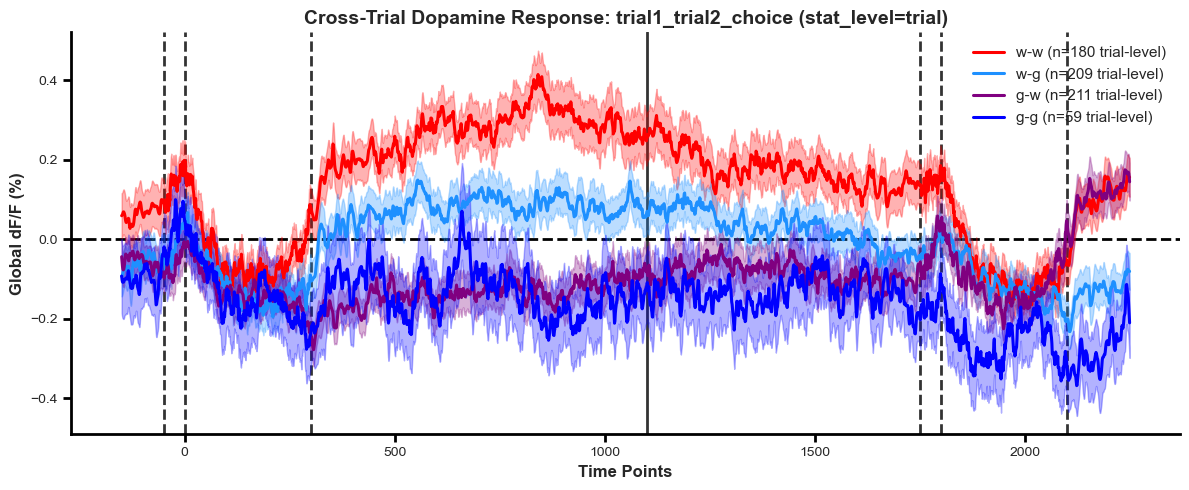

In [24]:
n_permutations = 0
# mouse level 统计
# plot_cross_trial_choice_transitions(DA_across_trial_wo_baseline, n_permutations=n_permutations, test_window=(250,350), stat_level='mouse')
# trial level 统计
plot_cross_trial_choice_transitions(DA_across_trial_wo_baseline, n_permutations=n_permutations, test_window=(250,350), stat_level='trial')


In [25]:
DA_across_trial_wo_baseline['cross_trial_warped_signal'].iloc[0].shape

(2400,)

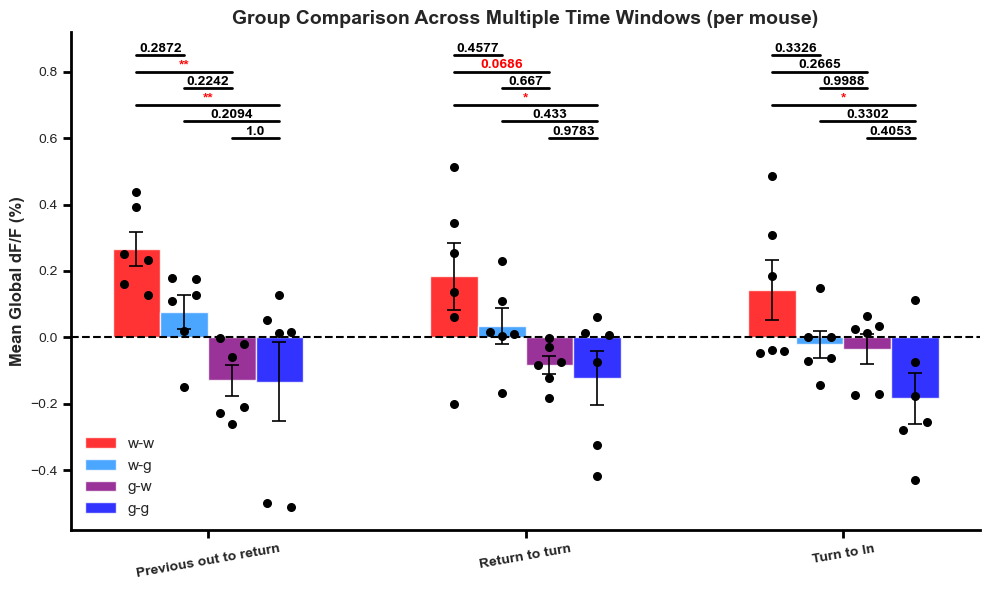

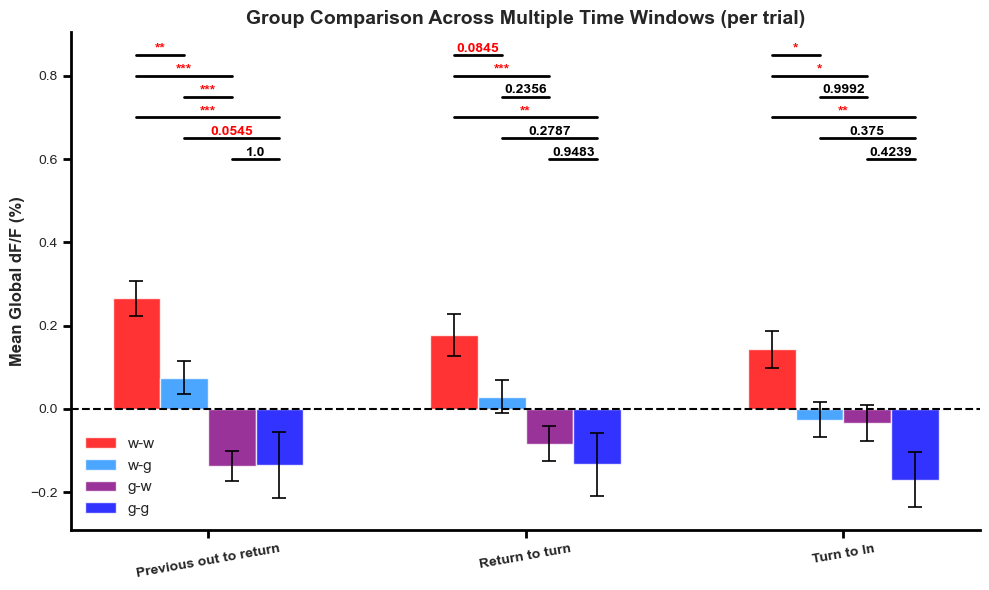

In [26]:
def visualize_group_comparison_multiple_windows(
    data,
    choice_type='trial1_trial2_choice',
    windows=[(450,1250), (1250,1900), (1900,1950)],
    labels=('Previous out to return',
            'Return to turn',
            'Turn to In'),
    use_nonparametric=False,
    show_points=True,
    stat_level='mouse'      # 新增参数: 'mouse' 或 'trial'
):
    """
    多时间窗口的组间比较（每只鼠先平均，再做统计与绘图）
    可选显示每只鼠的数据点

    Parameters
    ----------
    data : pd.DataFrame
        包含至少以下列：
        - choice_type：表示转换类型
        - cross_trial_warped_signal：信号
        - mouse_id：鼠编号
    """
    assert len(windows) == len(labels), "windows 和 labels 数量需一致"

    records = []

    # ========== 每只鼠自己平均 ==========
    for window, label in zip(windows, labels):
        start, end = window
        for g in TRANS_TYPES:
            g_data = data[data[choice_type] == g]
            if len(g_data) == 0:
                continue

            if stat_level == 'mouse':
                # 每只鼠先平均
                for mouse_id, mouse_df in g_data.groupby('mouse_id'):
                    signals = np.vstack(mouse_df['cross_trial_warped_signal'].values)
                    mean_signal = signals.mean(axis=0)
                    window_mean = mean_signal[start:end].mean()
                    records.append({
                        "group": g,
                        "window": label,
                        "mouse_id": mouse_id,
                        "value": window_mean
                    })
            elif stat_level == 'trial':
                # 每个 trial 单独记录
                for idx, row in g_data.iterrows():
                    signal = row['cross_trial_warped_signal']
                    window_mean = signal[start:end].mean()
                    records.append({
                        "group": g,
                        "window": label,
                        "mouse_id": row['mouse_id'],
                        "value": window_mean
                    })

    df = pd.DataFrame(records)

    # ========== 绘图 ==========
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(labels))
    width = 0.15
    bar_positions = {}

    means = df.groupby(['window', 'group'])['value'].mean()
    sems = df.groupby(['window', 'group'])['value'].sem()

    for i, group in enumerate(TRANS_TYPES):
        offsets = x + (i - len(TRANS_TYPES)/2) * width + width/2
        vals = [means[(label, group)] if (label, group) in means else 0 for label in labels]
        errs = [sems[(label, group)] if (label, group) in sems else 0 for label in labels]

        # 绘制柱子
        ax.bar(offsets, vals, width, yerr=errs, capsize=5,
               error_kw={'elinewidth':1.2, 'capthick':1.2},
               label=group, color=CHOICE_TRANSITION_COLORS[group], alpha=0.8)

        for j, label in enumerate(labels):
            sub_df = df[(df['window'] == label) & (df['group'] == group)]
            if len(sub_df) == 0:
                continue
            jitter_x = compute_smart_jitter(sub_df['value'], width=width, y_threshold_ratio=0.1)
            if show_points:
                ax.scatter(
                    offsets[j] + jitter_x,
                    sub_df['value'],
                    color='black',
                    s=30,
                    zorder=10,
                    marker='o'
                )

            bar_positions[(label, group)] = offsets[j]

    # ========== 统计检验 ==========
    for label in labels:
        sub_df = df[df['window'] == label]
        all_group_values = [sub_df[sub_df['group'] == g]['value'].values
                            for g in TRANS_TYPES if g in sub_df['group'].unique()]

        if len(all_group_values) < 2:
            continue

        # 单因素方差 or 非参数检验
        if use_nonparametric:
            stat, p = kruskal(*all_group_values)
        else:
            stat, p = f_oneway(*all_group_values)

        if p < 0.05:
            # Tukey事后检验
            values = np.concatenate(all_group_values)
            labels_for_tukey = np.concatenate(
                [[g]*len(vals) for g, vals in zip(TRANS_TYPES, all_group_values) if len(vals)>0]
            )
            tukey = pairwise_tukeyhsd(values, labels_for_tukey, alpha=0.05)
            tukey_df = pd.DataFrame(tukey._results_table.data[1:], columns=tukey._results_table.data[0])

            y_max = df['value'].max()
            y_offset = 0.05
            line_height = 0.6

            step = 0

            for _, row in tukey_df.iterrows():
                g1, g2, pval = row['group1'], row['group2'], row['p-adj']
                x1 = bar_positions[(label, g1)]
                x2 = bar_positions[(label, g2)]

                ax.plot([x1, x1, x2, x2],
                        [line_height, line_height+step, line_height+step, line_height],
                        color='k', linewidth=2)
                ax.text((x1+x2)/2, line_height+step+0.0003, significance_label(pval),
                        ha='center', va='bottom', fontsize=10,
                        fontweight='bold', color='red' if pval < 0.15 else 'black')
                line_height += y_offset

    # ========== 美化 ==========
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12, fontweight='bold', rotation=10)
    ax.set_ylabel("Mean Global dF/F (%)", fontsize=12, fontweight='bold')
    ax.set_title(f"Group Comparison Across Multiple Time Windows (per {stat_level})",
                 fontsize=14, fontweight='bold')
    ax.axhline(y=0, color='k', linestyle='--')
    ax.legend(fontsize=10, frameon=False)

    set_layout(ax)
    plt.tight_layout()
    plt.savefig(f'./figs/fig3/5.2 across trial stats (per {stat_level}).pdf')
    plt.show()
visualize_group_comparison_multiple_windows(DA_across_trial_wo_baseline, show_points=True, stat_level='mouse')
visualize_group_comparison_multiple_windows(DA_across_trial_wo_baseline, show_points=False, stat_level='trial')

## Save csv for prism

In [27]:
import pandas as pd
import numpy as np

def export_mean_signal_csv_multiwindow(data,
                                       choice_type='trial1_trial2_choice',
                                       trans_types=('w-w', 'w-g', 'g-w', 'g-g'),
                                       windows=[(450,1250), (1250,1900), (1900,1950), (2250, 2400)],
                                       labels=('previous out to return', 'return to turn', 'turn to in', 'after out')):
    """
    导出 mouse_level.csv 与 trial_level.csv：
      - 每行对应一个时间窗（3行）
      - 列依次为 w-w, w-g, g-w, g-g
      - 每种 transition 填充至全局最大长度（不足部分为 NaN）
    """

    def compute_records(stat_level):
        records = []
        for (start, end), win_label in zip(windows, labels):
            for t in trans_types:
                t_data = data[data[choice_type] == t]
                if len(t_data) == 0:
                    continue

                if stat_level == 'mouse':
                    for mouse_id, mouse_df in t_data.groupby('mouse_id'):
                        signals = np.vstack(mouse_df['cross_trial_warped_signal'].values)
                        mean_signal = signals.mean(axis=0)
                        win_mean = mean_signal[start:end].mean()
                        records.append({
                            "mouse_id": mouse_id,
                            "transition": t,
                            "time_window": win_label,
                            "mean_signal": win_mean
                        })
                elif stat_level == 'trial':
                    for _, row in t_data.iterrows():
                        signal = row['cross_trial_warped_signal']
                        win_mean = signal[start:end].mean()
                        records.append({
                            "transition": t,
                            "time_window": win_label,
                            "mean_signal": win_mean
                        })
        return pd.DataFrame(records)

    def build_and_save(df, stat_level):
        # 计算全局最大长度
        max_count = max([
            len(df[(df['transition'] == t) & (df['time_window']==w)]['mean_signal'].values)
            for w in labels
            for t in trans_types if len(df[df['transition'] == t]) > 0
        ])

        pivot_dict = {tw: [] for tw in labels}

        for t in trans_types:
            for tw in labels:
                sub_vals = df[(df['transition'] == t) & (df['time_window'] == tw)]['mean_signal'].tolist()
                sub_vals += [np.nan] * (max_count - len(sub_vals))
                pivot_dict[tw].extend(sub_vals)

        # 构造列名
        all_col_names = []
        for t in trans_types:
            all_col_names.extend([f"{t}_{i+1}" for i in range(max_count)])

        df_pivot = pd.DataFrame.from_dict(pivot_dict, orient='index', columns=all_col_names)
        df_pivot.index.name = 'time_window'

        filename = f"./data/results/stats_csv/M_mean_signal_{stat_level}.csv"
        df_pivot.to_csv(filename)
        print(f"✅ Exported: {filename}")

    # === 导出两种层级 ===
    df_mouse = compute_records('mouse')
    df_trial = compute_records('trial')

    build_and_save(df_mouse, 'mouse')
    build_and_save(df_trial, 'trial')

# 调用示例
export_mean_signal_csv_multiwindow(DA_across_trial_wo_baseline)


✅ Exported: ./data/results/stats_csv/M_mean_signal_mouse.csv
✅ Exported: ./data/results/stats_csv/M_mean_signal_trial.csv


(92, 600)


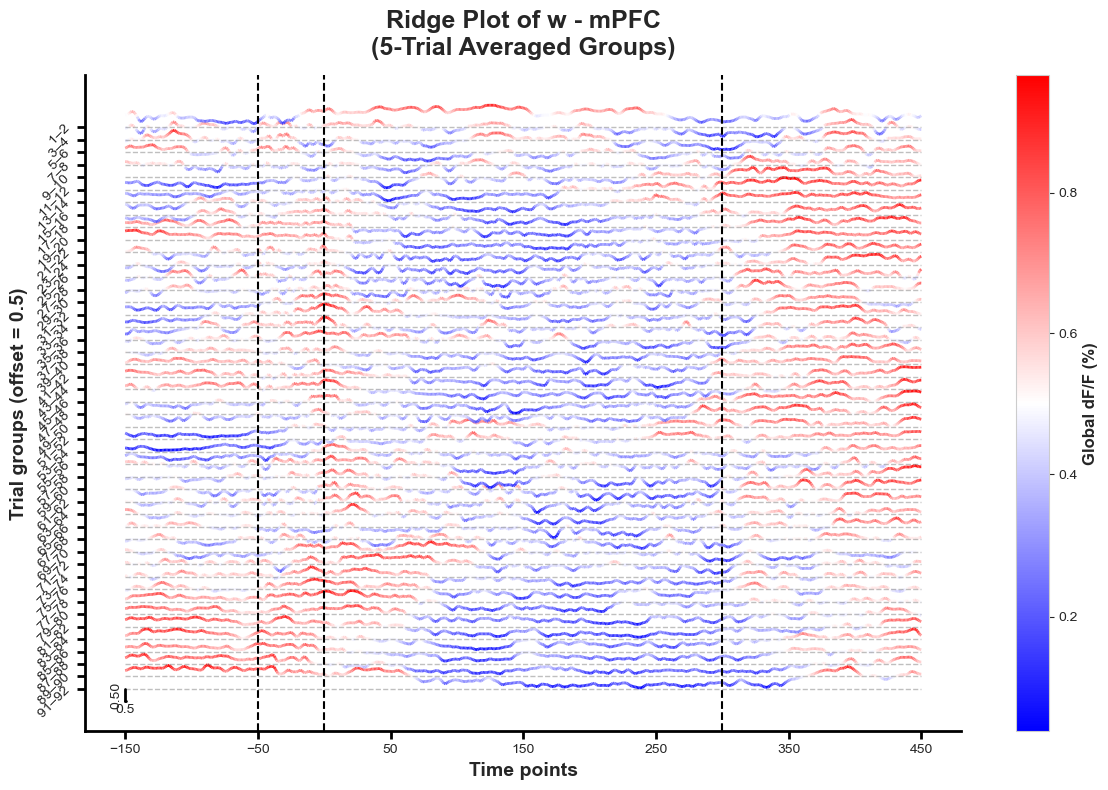

(68, 600)


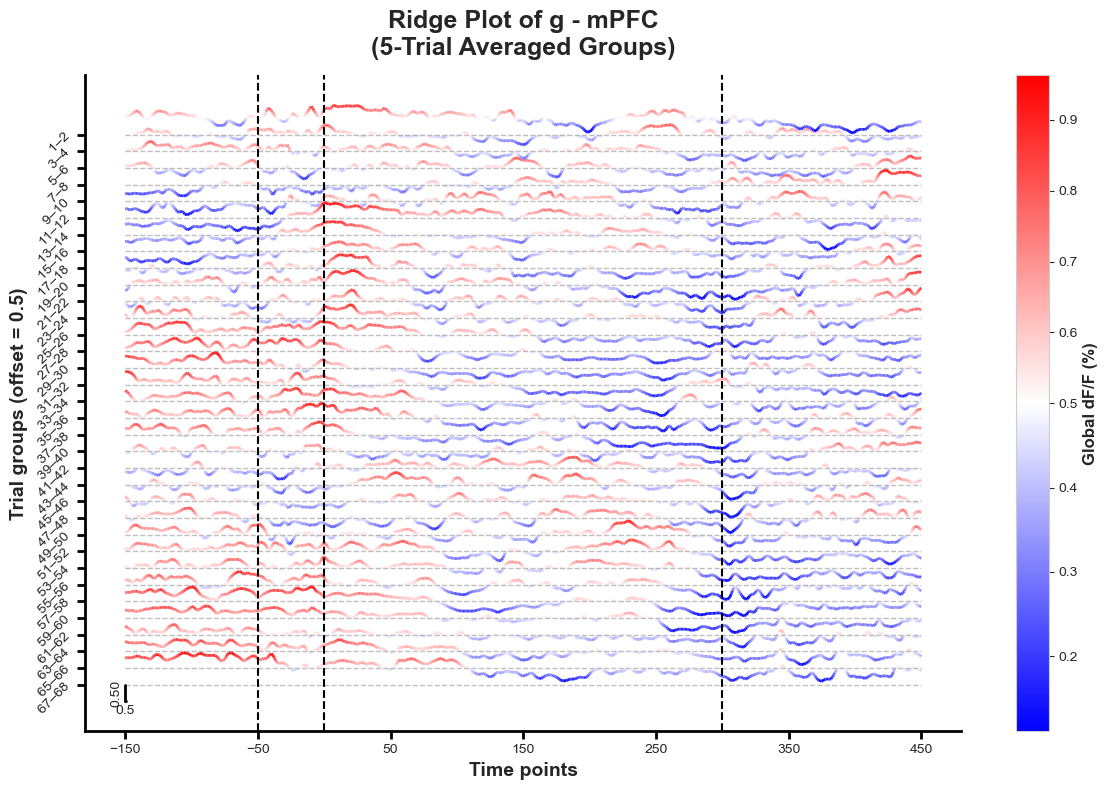

In [28]:
def plot_ridge(data, trial_type='w', smooth_sigma=10):
    """绘制Ridge图展示trial演变"""
    data = data['population_averages'][trial_type]['avg_matrix']
    print(data.shape)
    n_trials = len(data)
    n_timepoints = data.shape[1]
    smoothed_data = gaussian_filter(data, sigma=smooth_sigma)

    # 分组
    grouped_data = []
    group_labels = []
    group_size = 2

    for start_idx in range(0, n_trials, group_size):
        end_idx = min(start_idx + group_size, n_trials)
        group = smoothed_data[start_idx:end_idx]
        mean_signal = np.mean(group, axis=0)
        grouped_data.append(mean_signal)
        group_labels.append(f"Trials {start_idx+1}–{end_idx}")

    grouped_data = np.array(grouped_data)
    time_points = np.linspace(-150, 450, n_timepoints)
    n_groups = len(group_labels)

    # 全局 colormap
    cmap = plt.cm.bwr
    norm = mcolors.TwoSlopeNorm(vcenter=0.5)
    # norm = mcolors.Normalize()


    fig, ax = plt.subplots(figsize=(12, 8))
    offset = 0.5

    for i, idx in enumerate(reversed(range(n_groups))):
        y = grouped_data[idx] + i * offset
        baseline = i * offset

        points = np.array([time_points, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=2)
        lc.set_array(grouped_data[idx])
        ax.add_collection(lc)

        ax.hlines(baseline, time_points.min(), time_points.max(),
                 color="gray", linestyle="--", linewidth=1, alpha=0.5)

    ax.set_yticks([i * offset for i in range(n_groups)])
    ax.set_yticklabels([f"{lab[6:]}" for lab in reversed(group_labels)],
                       fontsize=10, rotation=45)
    ax.tick_params(axis='both', which='major', length=6, width=2, direction='out',
                  color='black', labelsize=10, bottom=True, left=True,
                  top=False, right=False)

    set_layout(ax)
    ax.set_xticks(np.arange(time_points.min(), time_points.max()+1, 100))
    ax.set_xlabel("Time points", fontsize=14, fontweight="bold")
    ax.set_ylabel(f"Trial groups (offset = {offset})", fontsize=14, fontweight="bold")

    # 添加比例尺
    scalebar_x = -150
    scalebar_y = -0.5
    scalebar_length_x = 0.5
    scalebar_length_y = offset

    ax.plot([scalebar_x, scalebar_x + scalebar_length_x],
           [scalebar_y, scalebar_y], color="k", lw=2)
    ax.plot([scalebar_x, scalebar_x],
           [scalebar_y, scalebar_y + scalebar_length_y], color="k", lw=2)
    ax.text(scalebar_x + scalebar_length_x / 2, scalebar_y - 0.1,
           f"{scalebar_length_x}", ha="center", va="top")
    ax.text(scalebar_x - 2, scalebar_y + scalebar_length_y / 2 - 0.01,
           f"{scalebar_length_y:.2f}", va="center", ha="right", rotation=90)

    # colorbar
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label("Global dF/F (%)", fontsize=12, fontweight="bold")

    ax.set_title(f"Ridge Plot of {trial_type} - {BRAIN_REGION}\n(5-Trial Averaged Groups)",
                fontsize=18, fontweight="bold", pad=15)

    plt.tight_layout()
    plt.grid(False)

    for mark in [DECISION_MAKING_INDEX, IN_INDEX, OUT_INDEX]:
        ax.axvline(x=mark-150, color="k", linestyle="--")

    plt.savefig(f"./figs/fig3/6.1 ridgeplot_{trial_type}.pdf", format="pdf")
    plt.show()

for trial_type in ['w', 'g']:
    plot_ridge(DA_matrix, trial_type, smooth_sigma=1)

In [29]:
# python
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from scipy.ndimage import gaussian_filter

def plot_heatmap_trials(data, trial_type='w', smooth_sigma=3, hlines=[20,50,80,110,140]):
    """
    每行对应一个 trial（从上到下第1个到最后），时间方向做高斯平滑，绘制热力图并在指定行画水平线。
    """
    mat = data['population_averages'][trial_type]['raw_matrix']  # shape: (n_trials, n_timepoints)
    n_trials, n_timepoints = mat.shape

    # 只在时间轴做平滑：sigma = (0, smooth_sigma)
    smoothed = gaussian_filter(mat, sigma=(0, smooth_sigma))

    time_points = np.linspace(-150, 450, n_timepoints)

    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = plt.cm.bwr
    norm = mcolors.TwoSlopeNorm(vcenter=0.5)

    # imshow：origin='upper' 使行 0 在最上面，extent 映射到时间轴和 trial 索引区间
    im = ax.imshow(smoothed, aspect='auto',
                   extent=[time_points.min(), time_points.max(), 0, n_trials],
                   origin='upper', cmap=cmap, norm=norm, interpolation='nearest')

    # y 轴刻度：根据试验数量选择显示间隔（例如每 10 个试验显示一次）
    if n_trials <= 30:
        y_ticks = np.arange(n_trials) + 0.5
        y_labels = (np.arange(n_trials) + 1).astype(str)
    else:
        step = max(1, n_trials // 20)
        y_ticks = np.arange(0, n_trials, step) + 0.5
        y_labels = (np.arange(0, n_trials, step) + 1).astype(str)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=9)

    ax.set_xlabel("Time points", fontsize=14, fontweight="bold")
    ax.set_ylabel("Trial (1 = top)", fontsize=14, fontweight="bold")

    # 在指定的行位置画水平线（注意 imshow 的 y 坐标从 0 到 n_trials，行边界在整数处）
    for h in hlines:
        # 如果要画在行与行之间的边界上，直接用整数 h 即可
        if 0 <= h <= n_trials:
            ax.axhline(h, color='k')

    # colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Global dF/F (%)", fontsize=12, fontweight="bold")

    # 事件竖线（若环境中有这些常量）
    for mark in [DECISION_MAKING_INDEX, IN_INDEX, OUT_INDEX]:
        ax.axvline(x=mark - 150, color="k", linestyle="--")

    set_layout(ax)
    ax.set_xticks(np.arange(time_points.min(), time_points.max()+1, 100))
    ax.set_title(f"Heatmap of {trial_type} - {BRAIN_REGION}\n(Trials top-to-bottom)",
                 fontsize=16, fontweight="bold", pad=12)

    plt.tight_layout()
    plt.grid(False)

    save_path = f"./figs/fig3/6.1_heatmap_{trial_type}.pdf"
    plt.savefig(save_path, format="pdf")
    plt.show()


In [30]:
import numpy as np

data = DA_matrix['population_averages']['all']['avg_matrix']  # shape: (n_units, n_timepoints)
# 对每个单元的200:350时间段计算均值和标准差
middle_mean = data[:, 200:350].mean(axis=1, keepdims=True)  # 每个单元一个均值
middle_std = data[:, 200:350].std(axis=1, keepdims=True)    # 每个单元一个标准差

# 按行z-score
DA_matrix_zscored = (data - middle_mean) / middle_std
data = {
    'population_averages': {'all':{'raw_matrix':DA_matrix_zscored}}
}

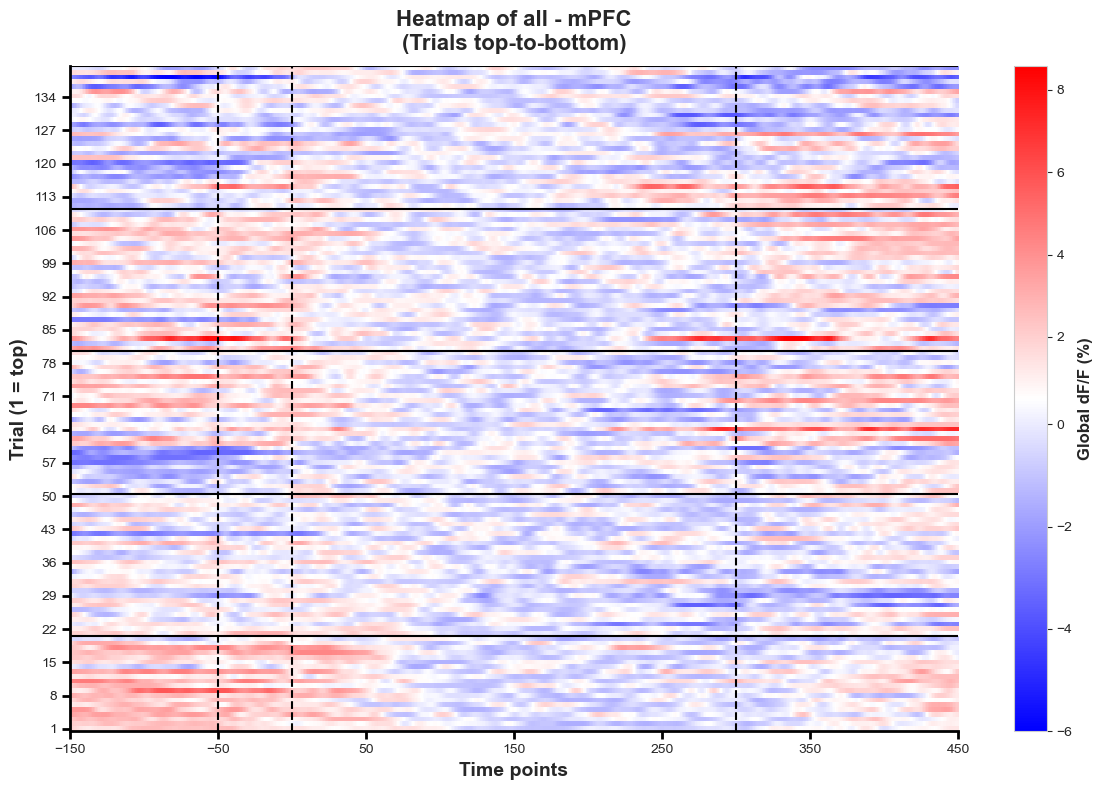

In [31]:
plot_heatmap_trials(data, trial_type='all')